# Technical Environment

## Pip Installs (Blank Technical Environment e.g. UCloud)
- Only relevant if the libraries have not been installed on your local machine or virtual environment
- Primarily relevant when using UCloud
- Can be commented out when irrelevant

In [ ]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install nltk
# %pip install scikit-learn
# %pip install wordcloud
# %pip install prettytable
# %pip install tensorflow

## Google Drive (GPU Set-Up)
- Relevant when using Google Colab
- It is of importance that the code zip is unpacked and uploaded with initial folder structure
- Should be commented out if unnecessary (e.g. local running or Ucloud), although it is highly recommended as GPU is absolutely necessary to run the tuning of the LSTM in particular

In [1]:
# Mount Google Drive to access shared project files directly within Colab
# This step enables loading preprocessed datasets

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Verify that a GPU is available and recognized by TensorFlow
# GPU acceleration is essential for training LSTM and transformer-based models efficiently.

import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Define the Google Collab Folder Path
- Only necessary for running on Google Colab
- When the original folder structure as handed in and outlined in the README was uploaded, you have to update this path
- Otherwise it will lead to difficulties when parsing the data

In [3]:
base_dir_collab = "/content/drive/MyDrive/Colab Notebooks/NLP_Final_Exam_All_Files" # <------ change for your own Google Drive Path of the Exam Folder "NLP_Final_Exam_All_Files"

## Clear Memory Function
- Just a custom function to improve code performance by clearing unused dataframes on demand

In [ ]:
## Defining a custom memory clear function to immprove performance

import gc
import time

def clear_unwanted_dataframes(preserve_names=None):
    """
    Clears DataFrames from global memory except for those explicitly named in preserve_names.
    Useful for freeing memory in notebooks while preserving only specified DataFrames.

    Parameters:
    - preserve_names (list of str, optional): List of variable names to keep in memory.
      If None, all DataFrames will be removed.
    """

    # Default to empty list if None provided
    if preserve_names is None:
        preserve_names = []

    # Count and list DataFrames currently present in memory before cleanup
    count_before = 0
    print("Listing DataFrames in memory before cleanup:")
    for obj in gc.get_objects():
        if isinstance(obj, pd.DataFrame):
            count_before += 1
    print(f"\n>>> Number of DataFrames in Memory: {count_before} <<<")
    print(f"\n{'-'*10}\n")

    # Run initial garbage collection to clear unreferenced objects
    gc.collect()

    # Count DataFrames after initial garbage collection
    count_after = sum(1 for obj in gc.get_objects() if isinstance(obj, pd.DataFrame))
    print(f"\n>>> Number of DataFrames after garbage collection clearing: {count_after} <<<\n")

    # Identify unwanted DataFrames in global namespace
    to_delete = [
        name for name, value in globals().items()
        if isinstance(value, pd.DataFrame) and name not in preserve_names
    ]

    # Delete each unwanted DataFrame explicitly
    for name in to_delete:
        del globals()[name]
        time.sleep(0.1)  # Optional pause to ensure safe deletion in interactive environments

    # Final garbage collection
    gc.collect()

    # Final count
    count_final = sum(1 for obj in gc.get_objects() if isinstance(obj, pd.DataFrame))
    print(f"\n>>> Number of DataFrames after final clearing: {count_final} <<<")


## Plotting Function
- A custom function helping with proper labelling for the class balance graphs

In [ ]:
def add_count_labels(ax, total=None, fmt="{count:.1f}k ({pct:.2f}%)"):
    """
    Annotates each bar in a bar chart with the absolute count and relative percentage.

    Parameters:
    - ax (matplotlib.axes.Axes): The axes containing the bar chart to annotate.
    - total (int, optional): Optional total value used for percentage calculation.
                             If None, the total is inferred from the bar heights.
    - fmt (str): Format string specifying how to display count and percentage.
                 Placeholders: 'count' in thousands and 'pct' as percentage.
    """
    if total is None:
        total = sum(bar.get_height() for bar in ax.patches)

    for container in ax.containers:
        for bar in container:
            count = bar.get_height()
            pct = (count / total) * 100
            label = fmt.format(count=count / 1000, pct=pct)

            ax.text(
                x=bar.get_x() + bar.get_width() / 2,
                y=count + total * 0.005,  # Slight offset for label visibility
                s=label,
                ha='center',
                va='bottom',
                fontsize=10,
                fontweight='light'
            )


def format_plot(ax, title=None, xlabel=None, ylabel=None, xticks=None):
    """
    Applies consistent styling and labeling to matplotlib/seaborn Axes.

    Parameters:
    - ax (matplotlib.axes.Axes): The plot to format.
    - title (str): Optional title for the plot.
    - xlabel (str): Optional x-axis label.
    - ylabel (str): Optional y-axis label.
    - xticks (list): Optional list of tick labels for the x-axis.
    """
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if xticks:
        ax.set_xticks(range(len(xticks)))  # Set tick positions based on number of classes
        ax.set_xticklabels(xticks)         # Apply custom labels

    # Slightly increase vertical limit to prevent label overlap
    ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
    ax.tick_params(axis='both', labelsize=10)


In [ ]:
def plot_target_distribution(df, column="target", hue="target", style="magma", title=None):
    """
    Visualizes the distribution of a binary classification target using a count plot.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the target column.
    - column (str): Column to visualize on the x-axis (typically 'target').
    - hue (str): Optional grouping column for bar separation. Defaults to the target.
    - style (str): Color theme name (unused in this version but preserved for future customization).
    - title (str): Optional title for the plot. Defaults to a descriptive title based on the column name.
    """
    plt.figure(figsize=(8, 6))

    # Generate a count plot with consistent styling across the project
    ax = sns.countplot(
        x=column,
        hue=hue,
        data=df,
        palette="Blues",
        legend=False,
        edgecolor="black",
        linewidth=0.5
    )

    # Annotate each bar with count and percentage
    add_count_labels(ax, total=len(df))

    # Manually assign tick labels for binary targets
    xtick_labels = ["True", "Fake"] if df[column].nunique() == 2 else None

    # Apply consistent formatting to title, labels, and axes
    format_plot(
        ax,
        title=title or f"Class Distribution of {column}",
        xlabel=column.capitalize(),
        ylabel="Count",
        xticks=xtick_labels
    )

    plt.tight_layout()
    plt.show()


## Importing Libraries

In [6]:
# Core Python and data libraries
import pandas as pd                    # Data manipulation
import numpy as np                     # Numerical operations
import re                              # Regular expressions
import random                          # Random number generation

# Visualization libraries
import matplotlib.pyplot as plt        # Static plotting
import seaborn as sns                  # Statistical plotting

# NLP preprocessing tools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import ngrams

# Machine learning and feature extraction
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score

# Deep learning with Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Transformer-based models
import torch
import transformers as ppb

# Miscellaneous
import warnings
from wordcloud import WordCloud
from prettytable import PrettyTable

## Dynamic File Paths

In [4]:
import sys
from pathlib import Path  # Import pathlib for handling file paths in a cross-platform manner

if "google.colab" in sys.modules:
    base_dir = Path(base_dir_collab)
else:
    base_dir = Path(__file__).parent.resolve()  # Automatic if Ucloud or Locally

print(base_dir) #Verifying the base directory

raw_data_dir = base_dir / "Raw Datasets" # Define the folder containing the dataset files
print(raw_data_dir) #Verifying the data directory

fake_data_path = raw_data_dir / "Fake.csv"
print(fake_data_path) #Verifying the path

true_data_path = raw_data_dir / "True.csv"
print(true_data_path) #Verifying the path"""

/content/drive/MyDrive/Colab Notebooks/NLP_Final_Exam_All_Files
/content/drive/MyDrive/Colab Notebooks/NLP_Final_Exam_All_Files/Raw Datasets
/content/drive/MyDrive/Colab Notebooks/NLP_Final_Exam_All_Files/Raw Datasets/Fake.csv
/content/drive/MyDrive/Colab Notebooks/NLP_Final_Exam_All_Files/Raw Datasets/True.csv


# Combine Dataframes

In [7]:
import random

# Set a fixed seed to ensure reproducibility of results across runs
# This applies to random sampling, NumPy operations, and TensorFlow models

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [8]:
# Load raw datasets for fake and true news articles
fake_df_raw = pd.read_csv(fake_data_path)
true_df_raw = pd.read_csv(true_data_path)

In [9]:
# Quick glance at the dataset
fake_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
# Quick glance at the dataset
true_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


## Creating Target Binary Encoding

In [ ]:
# We create the labels in each of the dataframes before joining

fake_df_raw["target"] = 1
true_df_raw["target"] = 0

fake_df_raw.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


## Concatenating Dataframes

In [ ]:
# We concatenate the two dataframes to create a master dataframe
df_raw = pd.concat([fake_df_raw, true_df_raw], ignore_index=True)

display(df_raw.info())
display(df_raw.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


None

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


# Exploratory Data Analysis (EDA)

## Check for Duplicates

In [ ]:
df_raw.duplicated().sum() # Check for duplicates

209

In [ ]:
# Duplicates were identified, and we decided to drop them
df_raw = df_raw.drop_duplicates()

# Verify success
df_raw.duplicated().sum()

0

## Investigating Class Balance

In [ ]:
## Class imbalance has been detected, as we will use logistic regression as one of the models, we must balance the dataset
## We will simply downsample the majority class (Fake) in this case so it matches the minority class (True)

df_raw['target'].value_counts()

target
1    23478
0    21211
Name: count, dtype: int64

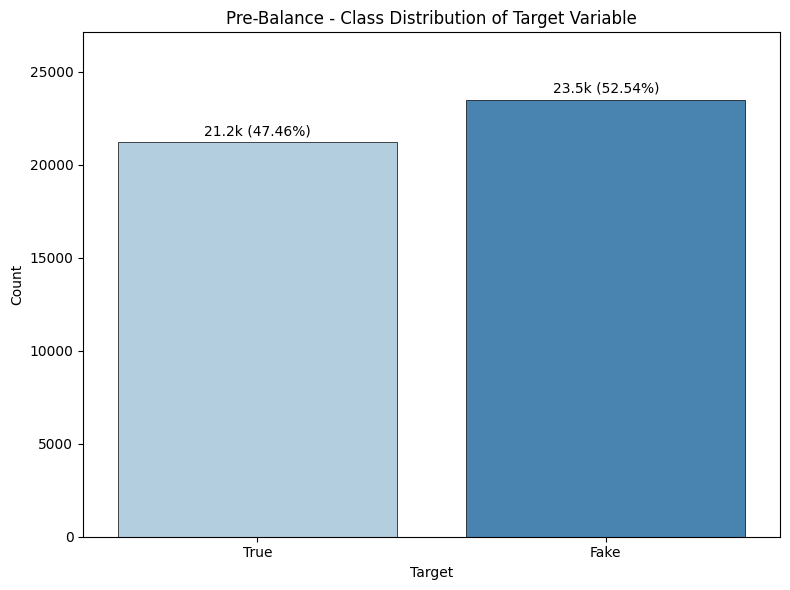

In [ ]:
## We visualize the distributions of the target variable
import matplotlib.pyplot as plt
import seaborn as sns

plot_target_distribution(
    df=df_raw,
    column="target",
    title="Pre-Balance - Class Distribution of Target Variable"
)

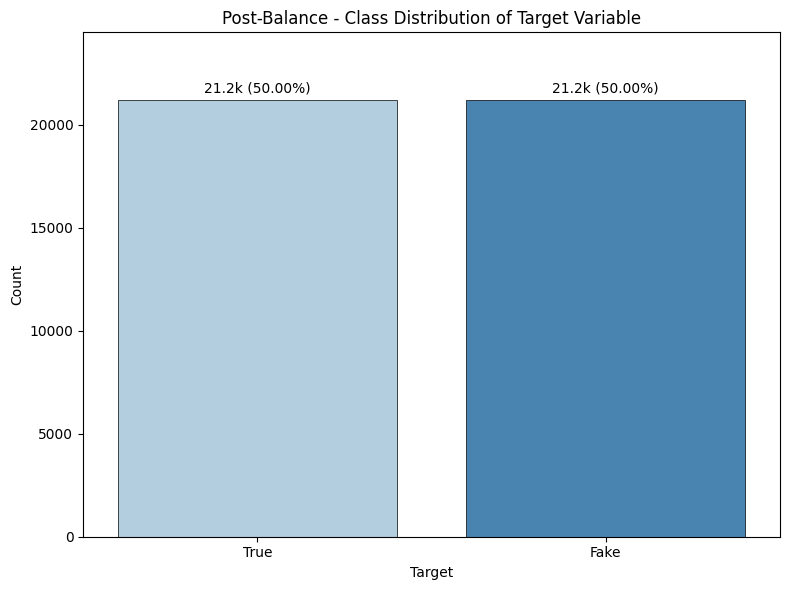

In [ ]:
minority_class_count = df_raw["target"].value_counts().min()

# Now we will downsample the majority class to exactly match the minority class

df_balanced_raw = pd.concat([
    df_raw[df_raw["target"] == 0].sample(minority_class_count, random_state=SEED),
    df_raw[df_raw["target"] == 1].sample(minority_class_count, random_state=SEED)
])


# Verifying the success with a plot
plot_target_distribution(
    df=df_balanced_raw,
    column="target",
    title="Post-Balance - Class Distribution of Target Variable"
)


## Articles by Subject

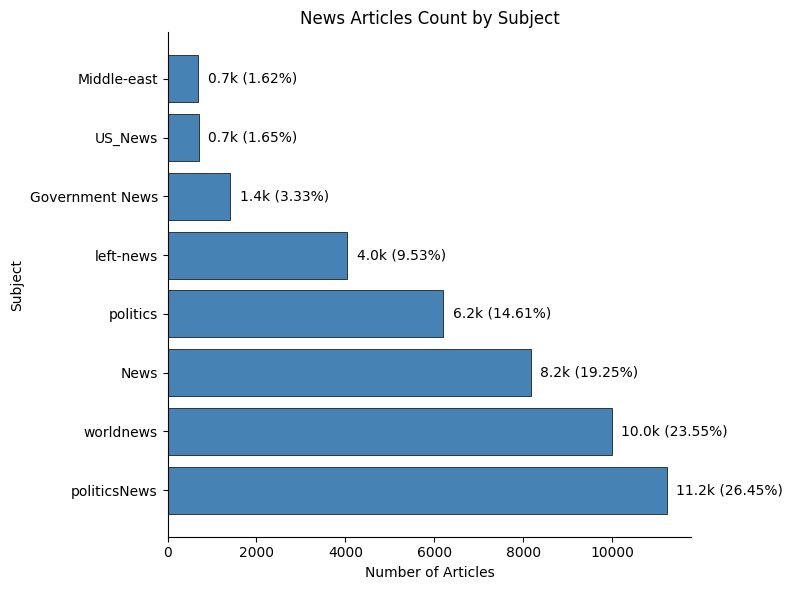

In [ ]:
# Compute counts
value_counts = df_balanced_raw["subject"].value_counts()
total = value_counts.sum()


# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(
    value_counts.index,
    value_counts.values,
    color="steelblue",
    edgecolor="black",
    linewidth=0.5)

# Add labels
for bar, count in zip(bars, value_counts.values):
    pct = (count / total) * 100
    label = f"{count/1000:.1f}k ({pct:.2f}%)"
    ax.text(
        count + total * 0.005,
        bar.get_y() + bar.get_height() / 2,
        label,
        va='center',
        fontsize=10,
        fontweight='light'
    )

# Styling
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Number of Articles")
ax.set_ylabel("subject".capitalize())
ax.set_title("News Articles Count by Subject")
ax.grid(False)
plt.tight_layout()
plt.show()

### Articles by Subject and Target

In [ ]:
# Group and count target labels per subject
subject_target_counts = df_balanced_raw.groupby(['subject', 'target']).size().unstack(fill_value=0)

# Rename columns for clarity
subject_target_counts = subject_target_counts.rename(columns={0: 'True', 1: 'Fake'})

# Add total row
subject_target_counts.loc['Total ='] = subject_target_counts.sum()

# Display the result
subject_target_counts

target,True,Fake
subject,,
Government News,0,1414
Middle-east,0,688
News,0,8168
US_News,0,701
left-news,0,4041
politics,0,6199
politicsNews,11220,0
worldnews,9991,0
Total =,21211,21211


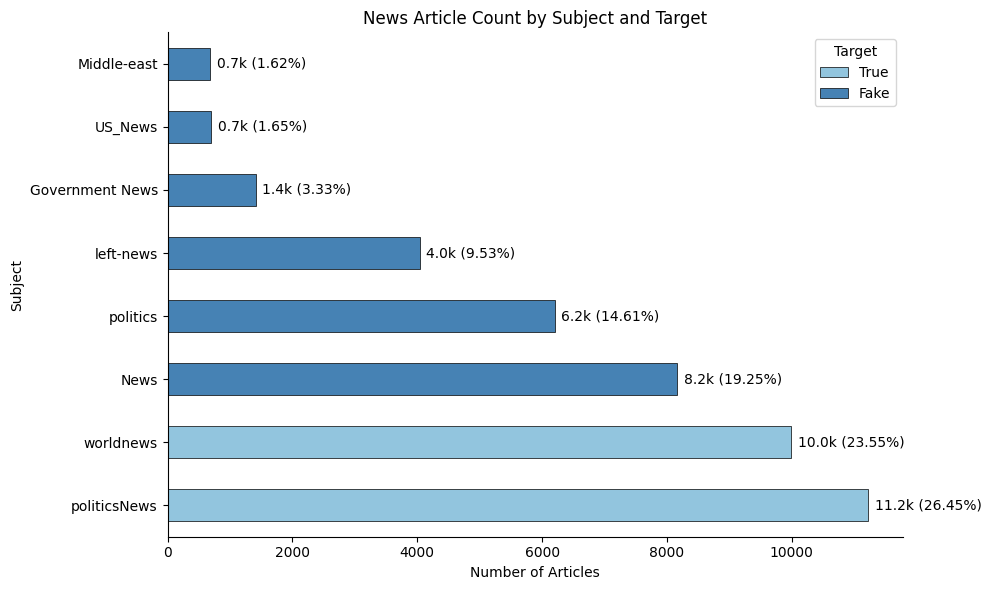

In [ ]:
# Create a grouped count DataFrame
subject_target_counts = df_balanced_raw.groupby(['subject', 'target']).size().reset_index(name='count')

# Pivot the DataFrame to get targets as columns
pivot_df = subject_target_counts.pivot(index='subject', columns='target', values='count').fillna(0)

# Rename target columns based on binary encoding: 0=True, 1=Fake
pivot_df = pivot_df.rename(columns={0: 'True', 1: 'Fake'})

# Define exact colors: Fake = dark, True = light
color_mapping = {
    'Fake': "#4682b4",   # Dark blue
    'True': "#92c5de"    # Light blue
}
colors = [color_mapping[col] for col in pivot_df.columns]

# Sort subjects by total articles (Fake + Real)
pivot_df["Total"] = pivot_df["Fake"] + pivot_df["True"]
pivot_df = pivot_df.sort_values("Total", ascending=False)
pivot_df = pivot_df.drop(columns="Total")

# Calculate total for percentage display
total_articles = pivot_df.values.sum()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = pivot_df.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor="black",
    linewidth=0.5
)

# Add labels (only on total bar height)
for idx, (subject, row) in enumerate(pivot_df.iterrows()):
    count_fake = row["True"]
    count_real = row["Fake"]
    total = count_fake + count_real
    pct = (total / total_articles) * 100
    label = f"{total/1000:.1f}k ({pct:.2f}%)"
    ax.text(
        total + total_articles * 0.0025,
        idx,
        label,
        va='center',
        fontsize=10,
        fontweight='light'
    )

# Styling
ax.set_title('News Article Count by Subject and Target')
ax.set_xlabel('Number of Articles')
ax.set_ylabel('Subject')
ax.legend(title='Target')
ax.grid(False)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


## Articles by Date

In [ ]:
from dateutil import parser

# Helper function to parse dates while handling malformed entries gracefully
def robust_date_parser(date_str):
    try:
        return parser.parse(date_str.strip())  # Attempt to parse cleaned date string
    except:
        return pd.NaT  # Return 'Not a Time' if parsing fails

# Apply the parser to the 'date' column and store the results in a new column
df_balanced_raw['date_parsed'] = df_balanced_raw['date'].astype(str).apply(robust_date_parser)

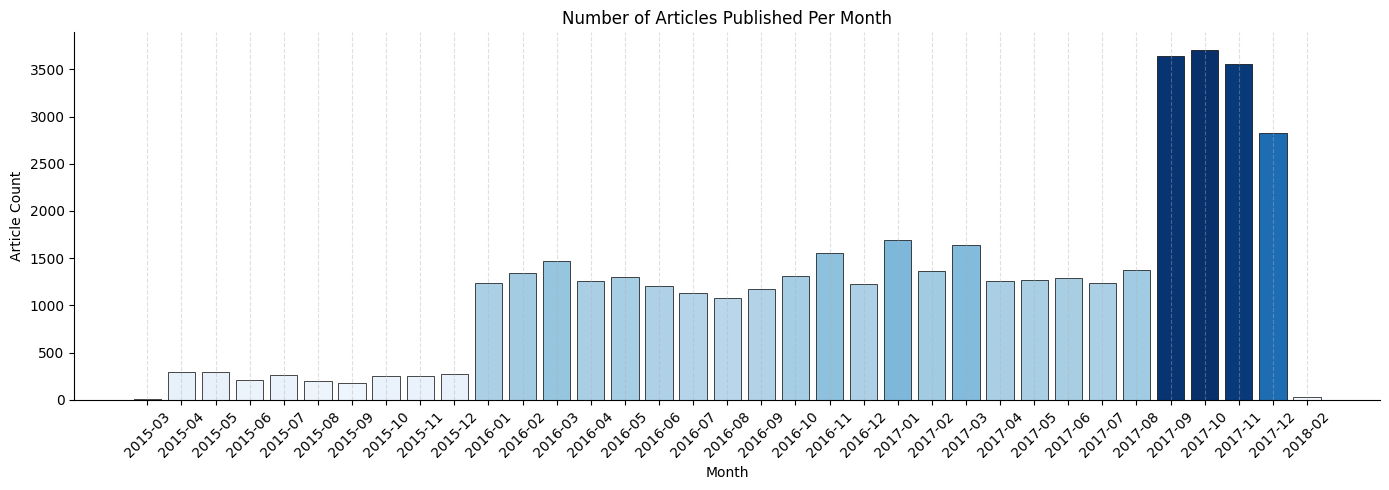

In [ ]:
import matplotlib.cm as cm

# Create a new column with monthly period
df_balanced_raw['month'] = df_balanced_raw['date_parsed'].dt.to_period('M')

# Count articles per month
monthly_counts = df_balanced_raw['month'].value_counts().sort_index()

# Normalize values for color scaling
norm = plt.Normalize(monthly_counts.min(), monthly_counts.max())
cmap = plt.colormaps["Blues"]
colors = [cmap(norm(v)) for v in monthly_counts]

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
bars = ax.bar(
    x=monthly_counts.index.astype(str),
    height=monthly_counts.values,
    color=colors,
    edgecolor="black",
    linewidth=0.5
)

# Formatting
ax.set_title('Number of Articles Published Per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Article Count')
ax.set_xticks(range(len(monthly_counts)))
ax.set_xticklabels(monthly_counts.index.astype(str), rotation=45)
ax.grid(axis='x', linestyle='--', alpha=0.4)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
df_balanced_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42422 entries, 40316 to 5656
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        42422 non-null  object        
 1   text         42422 non-null  object        
 2   subject      42422 non-null  object        
 3   date         42422 non-null  object        
 4   target       42422 non-null  int64         
 5   date_parsed  42415 non-null  datetime64[ns]
 6   month        42415 non-null  period[M]     
dtypes: datetime64[ns](1), int64(1), object(4), period[M](1)
memory usage: 2.6+ MB


## Drop irrelevant columns

In [ ]:
# Before we apply the pre-processing steps, we will drop all the irrelevant columns (date, date_parsed, month)
df_unprocessed = df_balanced_raw.drop(columns=["subject", 'date', 'date_parsed', 'month'])
df_unprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42422 entries, 40316 to 5656
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   42422 non-null  object
 1   text    42422 non-null  object
 2   target  42422 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


## Checking Null Values

In [ ]:
# We analyze the null values in the datase
df_unprocessed.isnull().sum()

title     0
text      0
target    0
dtype: int64

## Merge Title and Text

In [ ]:
# Before we apply the defined function, we will first join the title and text into a single text column
df_unprocessed["text"] = df_unprocessed["title"] + " " + df_unprocessed["text"]

In [ ]:
# Drop the title column
df_unprocessed = df_unprocessed.drop(columns=["title"])

In [ ]:
# Verify success
df_unprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42422 entries, 40316 to 5656
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    42422 non-null  object
 1   target  42422 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 994.3+ KB


# Pre-processing of Data

## Investigate Samples

In [ ]:
import textwrap

## Before we start preprocessing the text, we will take a look at the text data to understand its structure and content

samples = df_unprocessed["text"].sample(3) # Displaying a sample text from the dataset

for i, (idx, text) in enumerate(samples.items(), 1):
    print(f"\n--- Sample {i} (Index: {idx}) ---\n")
    print(textwrap.fill(text, width=140))
    print(f"\n--- End of Sample ---\n")


--- Sample 1 (Index: 6629) ---

 In RARE Case Of Factual Reporting, Fox Shows How Cruz Is Too Stupid To Run For President (VIDEO) For a party so terribly interested in
governing this country, Republicans sure do lack the basic knowledge about how governing actually works. One of the latest examples of this
is Ted Cruz and his choice to pick a vice presidential running mate at this stage in the process. In an incredibly rare case of factual
reporting, Fox News explained in detail exactly why Cruz completely screwed up by doing this in the video below.Cruz made a huge deal out of
the fact he picked a VP. He had a press conference just to announce it. Signs were made, people were cheering and then it turned out to be
Carly Fiorina? Her low popularity makes her a strange choice, but when you re Ted Cruz it s very likely you can t get a lot of the more
popular people to hang out with you.Unpopularity aside, Cruz s pick of a VP is actually pretty ignorant for another reason   and this has
n

In [ ]:
# Recording some interesting examples of unnormal cleaning cases - in this case artefacts from the crawler
sample_crawler_edge = [16863, 21294, 14709]

In [ ]:
# Utility function to identify rows containing a specific text snippet within a given column
def find_index_by_snippet(df, snippet, column="text"):
    matches = df[df[column].str.contains(snippet, regex=False, na=False)]
    return matches.index.tolist()

# Example: Locate indices containing a specific unwanted HTML snippet
snippet = "<![CDATA[ (function(d, s, id)"
matched_indices = find_index_by_snippet(df_unprocessed, snippet)
print("Matched indices:", matched_indices)


Matched indices: [21294, 15115, 14890, 14709, 21071, 14768, 14802, 14728, 21230, 16868, 16822, 16870, 21114, 16859, 16845, 14887, 15218, 14775, 14664, 14834, 21098, 16863, 21386, 21150, 16929, 19969, 14626, 21247, 21131, 21255, 14698, 16901]


In [ ]:
# Display full text content for a list of row indices, formatted for readability
def display_text_by_indices(df, indices, column="text", width=120):
    for i, idx in enumerate(indices, 1):
        text = df.at[idx, column]
        print(f"\n--- Sample {i} (Index: {idx}) ---\n")
        print(textwrap.fill(text, width=width))  # Wrap text for cleaner console output
        print(f"\n--- End of Sample ---\n")

# Display example crawler-affected entries for manual inspection
display_text_by_indices(df_unprocessed, sample_crawler_edge)


--- Sample 1 (Index: 16863) ---

MONTEL WILLIAMS Says Oregon Patriots Are “Undereducated Terrorist Buffoons” And National Guard Should “Shoot To Kill”
Them He s pro-gun, pro-military, anti-fracking and anti-wrongful imprisonment of US veterans in Mexico. But TV
personality Montel Williams has found himself in hot water with conservatives after making some outrageous claims on
Twitter about the patriots protesting federal government overreach in Oregon:  And here, pro-gun and conservative (on
some issues) Montel Williams, makes an apology for his comments on Twitter, along with an explanation about why he made
them:// <![CDATA[ (function(d, s, id) { var js, fjs = d.getElementsByTagName(s)[0]; if (d.getElementById(id)) return; js
= d.createElement(s); js.id = id; js.src = "//connect.facebook.net/en_GB/sdk.js#xfbml=1&#038;version=v2.3";
fjs.parentNode.insertBefore(js, fjs);}(document, 'script', 'facebook-jssdk')); // ]]>Since I am trending apparently, let
s clear somethings up about #Ore

## Custom Text Pre-Processing Function

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/manfri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manfri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/manfri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/manfri/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

| **Task Type**                             | **Lemmatize or Stem** | **Return Format** | **Reason**                                                                  |
| ----------------------------------------- | --------------------- | ----------------- | --------------------------------------------------------------------------- |
| Text classification (e.g., spam, emotion) | Lemmatization         | String            | Models like `TfidfVectorizer` need clean, readable text for features.       |
| Sentiment analysis                        | Lemmatization         | String            | Preserving correct word form helps interpret tone (e.g., "good", "better"). |
| Topic modeling (e.g., LDA)                | Stemming              | List              | Root words improve clustering of similar terms.                             |
| Search engine / IR                        | Stemming              | String            | Indexing often benefits from broader matches via stems.                     |
| Chatbots / Language modeling              | Lemmatization         | String            | Lemmas retain meaning, useful for generating natural responses.             |
| Social media analysis                     | Stemming              | String or List    | Faster, tolerant of noisy informal data.                                    |
| Document classification                   | Lemmatization         | String            | Clean, semantically accurate inputs help with feature extraction.           |
| Named Entity Recognition (NER)            | Lemmatization         | List              | Token-level meaning matters; stems may distort entity names.                |
| Keyword extraction                        | Lemmatization         | List              | Semantic accuracy ensures better keyword quality.                           |
| Clustering / Unsupervised tasks           | Stemming              | List              | Grouping benefits from broader generalization.                              |


In [ ]:
# We define a custom function for cleaning and preprocessing the text before model training
# This ensures consistency across our dataset and allows us to easily modify the process later if needed

import re
import html
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize


# Initialize tools from NLTK
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def text_preprocessing(
    text,
    fix_contractions=True,
    remove_punctuation=True,
    use_lemmatization=True,
    return_as_string=True
):
    """
    Cleans and preprocesses a given text string for NLP model training.

    This function applies conservative text cleaning steps including HTML decoding,
    unicode normalization, removal of JavaScript/web artifacts, and optional
    token-level processing such as stopword removal, lemmatization or stemming.

    Parameters:
    ----------
    text : str
        The raw input text to be cleaned.

    fix_contractions : bool, default=True
        Whether to attempt fixing broken contractions (e.g., "he s" → "he's").

    remove_punctuation : bool, default=True
        Whether to remove all punctuation from the text.

    use_lemmatization : bool, default=True
        If True, lemmatize the tokens; if False, apply stemming instead.

    return_as_string : bool, default=True
        If True, returns a single string; if False, returns a list of tokens.

    Returns:
    -------
    str or list
        The cleaned and processed text, either as a space-separated string or list of tokens.
    """

    # Decode HTML entities (e.g., &amp;)
    text = html.unescape(text)

    # Normalize Unicode characters (e.g., accented letters, weird symbols)
    text = unicodedata.normalize("NFKD", text)

    # Remove embedded JS/SDK/Crawler artifacts
    text = re.sub(r"<!\[CDATA\[.*?\]\]>", " ", text, flags=re.DOTALL)
    text = re.sub(r"\(\s*function\s*\(.*?\)\s*\{.*?\}\)\s*\(.*?\);", " ", text, flags=re.DOTALL)
    text = re.sub(r"(//)?connect\.facebook\.net.*?(\n|$)", " ", text, flags=re.IGNORECASE)

    # Fix broken contractions (e.g., "he s" → "he's")
    if fix_contractions:
        text = re.sub(r"\b([A-Za-z]+) s\b", r"\1's", text)
        text = re.sub(r"\b([A-Za-z]+) re\b", r"\1're", text)
        text = re.sub(r"\b([A-Za-z]+) t\b", r"\1't", text)
        text = re.sub(r"\b([A-Za-z]+) ll\b", r"\1'll", text)

    # Convert the text to lowercase
    text = text.lower()

    # Remove URLs and leftover HTML tags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'<.*?>', '', text)

    # Optionally remove punctuation (keeping only words and spaces)
    if remove_punctuation:
        text = re.sub(r"[^\w\s]", "", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize the cleaned text
    tokens = word_tokenize(text)

    # Filter tokens (remove stopwords and keep alphabetic words only)
    filtered_tokens = [t for t in tokens if t.isalpha() and t not in stop_words]

    # Lemmatize or stem depends on the occasion
    if use_lemmatization:
        processed_tokens = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    else:
        processed_tokens = [stemmer.stem(t) for t in filtered_tokens]

    # Return either list or string depends on occasion
    return ' '.join(processed_tokens) if return_as_string else processed_tokens

In [ ]:
# Apply the Custom Pre-Processing Function
df_unprocessed["text"] = df_unprocessed["text"].apply(text_preprocessing)

In [ ]:
#Copy dataframe to not alter the previous one

df = df_unprocessed.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42422 entries, 40316 to 5656
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    42422 non-null  object
 1   target  42422 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


In [ ]:
# Quick glance at the text column
df["text"].head()

40316    israel say intensify response syrian fire jeru...
37551    assad adviser say rebel must lay arm syrian st...
39932    taiwan president call breakthrough china relat...
30828    trump considering rep hensarling treasury secr...
37283    turkey say u want use gold trader case impose ...
Name: text, dtype: object

---
# Word Clouds per Target

## Fake News - Word Cloud

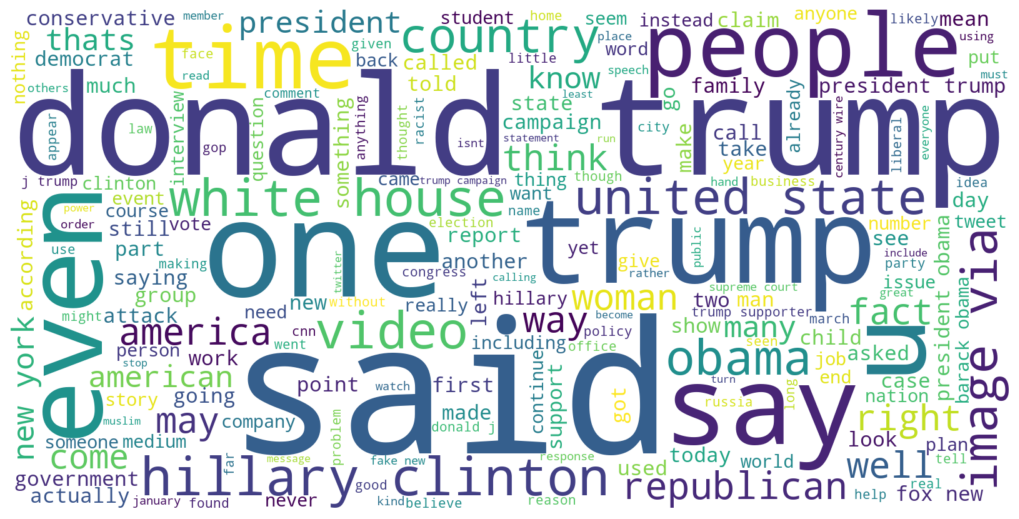

In [ ]:
# Generate a word cloud from the text of all fake news articles

# Subset the dataset to include only entries labeled as fake (target = 1)
fake_news = df[df['target'] == 1]

# Combine all article texts into a single string
common_words = " ".join(fake_news['text'].astype(str).tolist())

# Create and configure the word cloud object
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white'  # Set background to white for print-friendly output
).generate(common_words)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axes for visual clarity
plt.tight_layout(pad=0)
plt.show()

## True News - Word Cloud

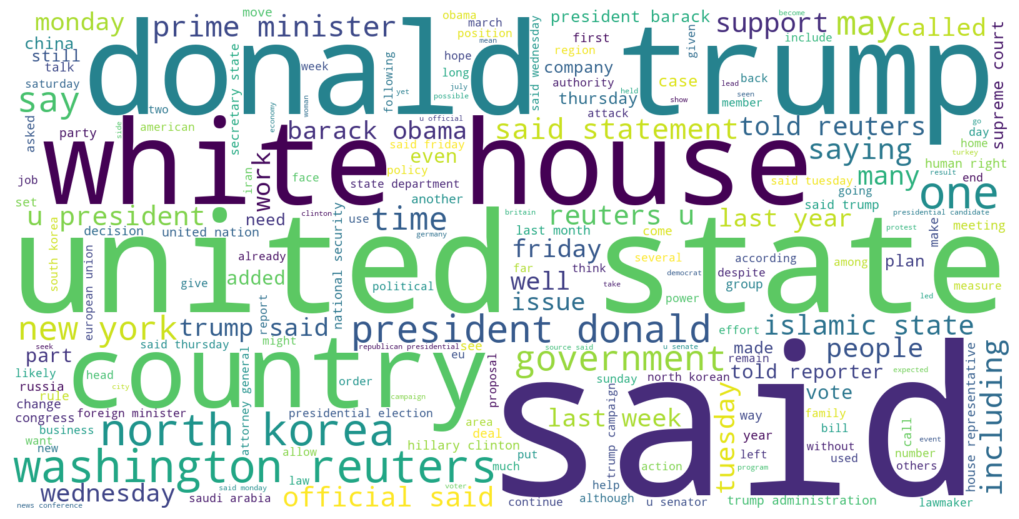

In [ ]:
# Generate a word cloud from the text of all real news articles

# Subset the dataset to include only entries labeled as true (target = 0)
real_news = df[df['target'] == 0]

# Concatenate all article texts into a single string
common_words = " ".join(real_news['text'].astype(str).tolist())

# Create the word cloud object with a white background
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white'
).generate(common_words)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes for a cleaner visualization
plt.tight_layout(pad=0)
plt.show()

# N-grams from a sample article

In [ ]:
# Extract a sample news article for token-level analysis
sample_text = df['text'].iloc[0]

# Generate unigrams, bigrams, and trigrams from a given sentence using NLTK's tokenizer and ngram utility
def get_ngrams(sentence):
    tokens = word_tokenize(sentence)
    n1_grams = list(ngrams(tokens, 1))
    n2_grams = list(ngrams(tokens, 2))
    n3_grams = list(ngrams(tokens, 3))
    return n1_grams, n2_grams, n3_grams

# Apply the function to extract n-gram lists from the sample
n1_list, n2_list, n3_list = get_ngrams(sample_text)

# Format and display unigrams as a table
n1_table = PrettyTable(['Index', 'Word'])
n1_table.title = 'Unigrams for the sample news text'
for i, t in enumerate(n1_list, 1):
    n1_table.add_row([i, t[0]])
print(n1_table)

# Format and display bigrams as a table
n2_table = PrettyTable(['Index', 'Word 1', 'Word 2'])
n2_table.title = 'Bigrams for the sample news text'
for i, t in enumerate(n2_list, 1):
    n2_table.add_row([i, t[0], t[1]])
print(n2_table)

# Format and display trigrams as a table
n3_table = PrettyTable(['Index', 'Word 1', 'Word 2', 'Word 3'])
n3_table.title = 'Trigrams for the sample news text'
for i, t in enumerate(n3_list, 1):
    n3_table.add_row([i, t[0], t[1], t[2]])
print(n3_table)

+-----------------------------------+
| Unigrams for the sample news text |
+---------+-------------------------+
|  Index  |           Word          |
+---------+-------------------------+
|    1    |          israel         |
|    2    |           say           |
|    3    |        intensify        |
|    4    |         response        |
|    5    |          syrian         |
|    6    |           fire          |
|    7    |     jerusalembeirut     |
|    8    |         reuters         |
|    9    |           five          |
|    10   |        projectile       |
|    11   |          syria          |
|    12   |           set           |
|    13   |           air           |
|    14   |           raid          |
|    15   |          siren          |
|    16   |         israeli         |
|    17   |           town          |
|    18   |         saturday        |
|    19   |        prompting        |
|    20   |         israeli         |
|    21   |         military        |
|    22   | 

---
# Splitting into Train / (Validation) / Test

In [ ]:
from sklearn.model_selection import train_test_split

# First split into X and y
X = df['text']
y = df['target']

# Train-test split (Regular Approach)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# Optional Step 2: Split test set into validation and test (e.g., 10% each)
use_validation = False  # Toggle this to False if you don’t want validation

if use_validation:
    X_val, X_test, y_val, y_test = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test, random_state=SEED
    )
else:
    X_val, y_val = None, None  # No validation set used

## Clear unwanted Dataframes

In [ ]:
# Free Up Computational Resources

dataframes_to_keep = ["X_train", "X_test", "y_train", "y_test", "df_raw", "df"]

clear_unwanted_dataframes(dataframes_to_keep)

Listing DataFrames in memory before cleanup:

>>> Number of DataFrames in Memory: 13 <<<

----------


>>> Number of DataFrames after garbage collection clearing: 13 <<<



/var/folders/3h/4yzlbv2s64v4kj772dgl10n00000gn/T/ipykernel_11542/1992010628.py:24: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if isinstance(obj, pd.DataFrame):
/var/folders/3h/4yzlbv2s64v4kj772dgl10n00000gn/T/ipykernel_11542/1992010628.py:33: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  count_after = sum(1 for obj in gc.get_objects() if isinstance(obj, pd.DataFrame))



>>> Number of DataFrames after final clearing: 5 <<<


/var/folders/3h/4yzlbv2s64v4kj772dgl10n00000gn/T/ipykernel_11542/1992010628.py:51: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  count_final = sum(1 for obj in gc.get_objects() if isinstance(obj, pd.DataFrame))


---
# Vectorization of Text

## Bag of Words (BoW)
- Converting the text into simple word frequencies
- No order, context, or meaning.
- Quick Baseline for Basic Models

In [ ]:
bow_vectorizer = CountVectorizer(
    tokenizer=lambda x: x,          # We already tokenized the text
    preprocessor=lambda x: x,       # We already preprocessed the text
    max_features=15000,
    ngram_range=(1, 2),             # Unigrams + bigrams
    min_df=3,
    max_df=0.8
)

| Param        | Typical Value                      | Good For                     |
| ------------ | ---------------------------------- | ---------------------------- |
| `min_df=3`   | Keep words seen in at least 3 docs | Removing rare garbage        |
| `max_df=0.8` | Remove words in >80% of docs       | Avoiding common filler terms |


In [ ]:
# Fit only on training data
X_train_bow = bow_vectorizer.fit_transform(X_train.apply(lambda x: x.split()))

# Transform test (and optionally validation) data
X_test_bow = bow_vectorizer.transform(X_test.apply(lambda x: x.split()))

if use_validation:
    X_val_bow = bow_vectorizer.transform(X_val.apply(lambda x: x.split()))
else:
    X_val_bow = None

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Validate Sucess
X_train_bow.shape

(33937, 15000)

## Term Frequency-Inverse Document Frequency (TF-IDF)
- Same as BoW but down-weighting common words and up-weighting rare words
- Good for linear models and large vocabularies, when highlighting of "unique" terms important

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,          # We already tokenized the text
    preprocessor=lambda x: x,       # We already preprocessed the text
    max_features=15000,
    ngram_range=(1, 2),             # Unigrams + bigrams
    min_df=3,
    max_df=0.8
)

In [ ]:
# Fit the vectorizer on the tokenized training text
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.apply(lambda x: x.split()))

# Transform the test text using the trained vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test.apply(lambda x: x.split()))

# If using a validation set, transform that as well
if use_validation:
    X_val_tfidf = tfidf_vectorizer.transform(X_val.apply(lambda x: x.split()))
else:
    X_val_tfidf = None

In [ ]:
# Validate sucess
X_train_tfidf.shape

(33937, 15000)

## Padding & Embedding
- Embedding layers convert words into dense, low-dimensional vectors that capture semantic meaning and improve generalization in text classification.
- Padding ensures all sequences have the same length, enabling batch processing in LSTM models.
- Together, padding and embedding allow variable-length textual input to be transformed into a fixed-size numeric format suitable for deep learning.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define tokenizer and fit it only on training text
embedding_tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
embedding_tokenizer.fit_on_texts(X_train)

# Convert to sequences (lists of word indices)
X_train_seq = embedding_tokenizer.texts_to_sequences(X_train)
X_test_seq = embedding_tokenizer.texts_to_sequences(X_test)
if use_validation:
    X_val_seq = embedding_tokenizer.texts_to_sequences(X_val)

# Pad sequences to fixed length
max_seq_len = 300
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len, padding='post', truncating='post')
if use_validation:
    X_val_pad = pad_sequences(X_val_seq, maxlen=max_seq_len, padding='post', truncating='post')
else:
    X_val_pad = None

# Training the Models

## Logistic Regression (Log Reg)

### LogReg - Bag of Words (BoW)

#### LogReg: Train the Model (BoW)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Fit the Logistic Regression Model
log_reg_bow = LogisticRegression()
log_reg_bow.fit(X_train_bow, y_train)

LogisticRegression()

#### LogReg: Find ideal threshold (BoW)

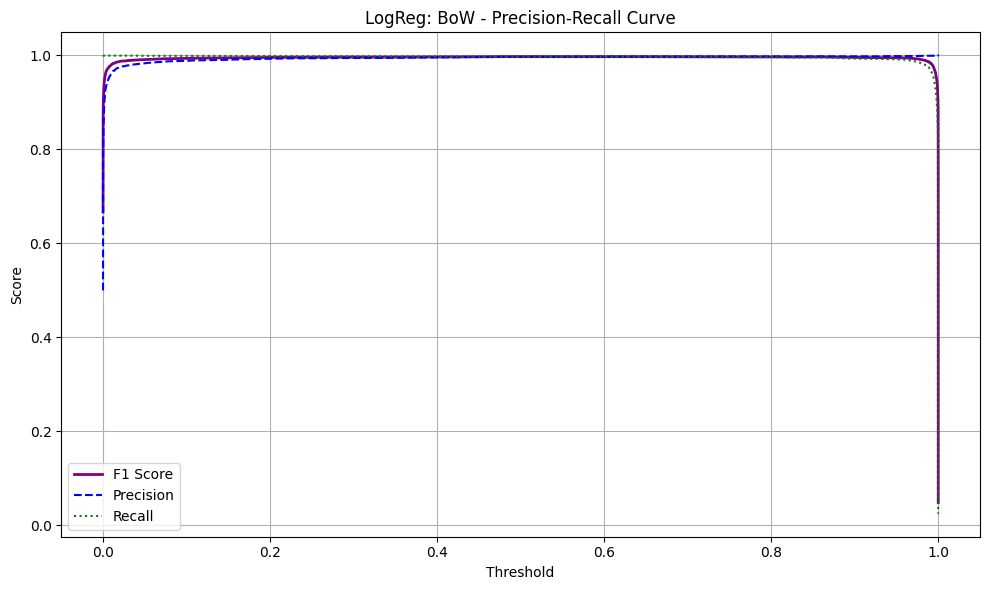

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Predict probability scores for the positive class (Fake) using the BoW-based logistic regression model
y_probs_lr = log_reg_bow.predict_proba(X_test_bow)[:, 1]

# Compute precision, recall, and decision thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_lr)

# Compute F1 scores at each threshold (adding epsilon to avoid division by zero)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Plot F1, precision, and recall as functions of the classification threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='purple', linewidth=2)
plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', linestyle=':', color='green')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('LogReg: BoW - Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


#### LogReg: Evaluate on Test Data (BoW)


--- Threshold: 0.5 ---
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4243
        Fake       1.00      1.00      1.00      4242

    accuracy                           1.00      8485
   macro avg       1.00      1.00      1.00      8485
weighted avg       1.00      1.00      1.00      8485



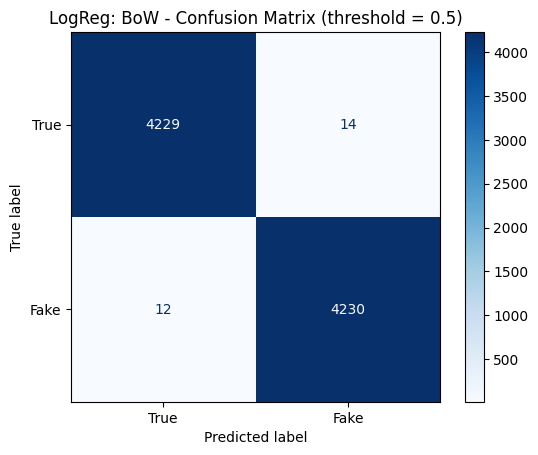


--- Threshold: 0.55 ---
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4243
        Fake       1.00      1.00      1.00      4242

    accuracy                           1.00      8485
   macro avg       1.00      1.00      1.00      8485
weighted avg       1.00      1.00      1.00      8485



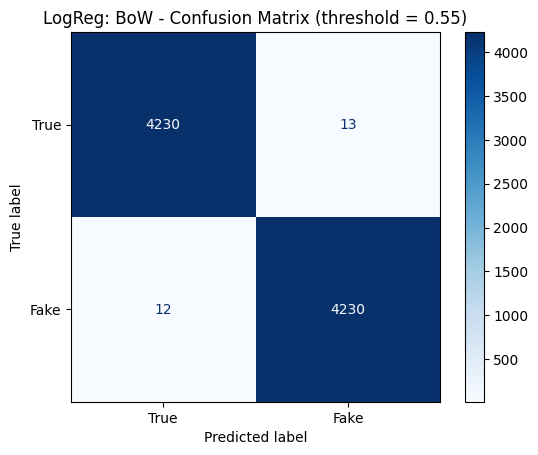


--- Threshold: 0.6 ---
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4243
        Fake       1.00      1.00      1.00      4242

    accuracy                           1.00      8485
   macro avg       1.00      1.00      1.00      8485
weighted avg       1.00      1.00      1.00      8485



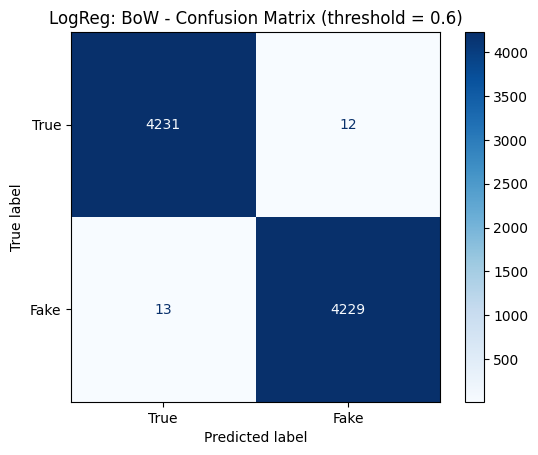


--- Threshold: 0.8 ---
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4243
        Fake       1.00      1.00      1.00      4242

    accuracy                           1.00      8485
   macro avg       1.00      1.00      1.00      8485
weighted avg       1.00      1.00      1.00      8485



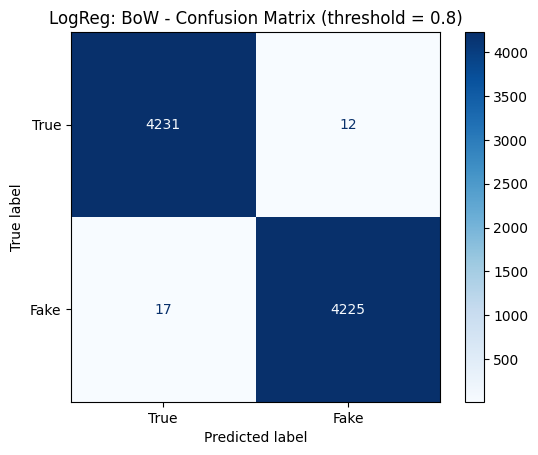

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Define thresholds to evaluate performance trade-offs for the BoW-based logistic regression model
thresholds_to_test_bow = [0.5, 0.55, 0.6, 0.8]

# Loop through each threshold and compute evaluation metrics
for threshold in thresholds_to_test_bow:
    # Convert probabilities to binary predictions based on current threshold
    y_pred_bow = (y_probs_lr >= threshold).astype(int)

    print(f"\n--- Threshold: {threshold} ---")

    # Print classification metrics (precision, recall, F1) with explicit label mapping
    print(classification_report(
        y_test,
        y_pred_bow,
        zero_division=0,
        labels=[0, 1],
        target_names=["True", "Fake"]
    ))

    # Display confusion matrix with correct label order and consistent styling
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_bow,
        cmap='Blues',
        labels=[0, 1],
        display_labels=["True", "Fake"]
    )

    plt.title(f"LogReg: BoW - Confusion Matrix (threshold = {threshold})")
    plt.show()

#### LogReg: Tune the model (BoW)

##### LogReg: Hyperparemeter Grid Search (BoW)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a pipeline for logistic regression using the bag-of-words representation
# This structure enables seamless hyperparameter tuning and potential feature preprocessing
pipeline_bow = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000))  # Increase max_iter for convergence stability
])

# Define the hyperparameter grid for tuning
# These values were selected based on prior tests and learning curve observations
param_grid_bow = {
    'logreg__C': [1000],                    # Inverse regularization strength; higher values = less regularization
    'logreg__penalty': ['l2'],              # L2 penalty chosen for simplicity and generalizability
    'logreg__solver': ['liblinear']         # Suitable for small/medium datasets and L2 regularization
}

# Note: Other tested values (not included here for runtime efficiency):
# C: 0.01, 0.1, 1, 10, 20, 50, 10000, 20000, 50000
# penalty: 'elasticnet'
# solver: 'saga', 'newton-cg', 'sag', 'lsqr', 'lbfgs'

In [ ]:
from sklearn.model_selection import GridSearchCV

# Set up GridSearchCV to perform hyperparameter tuning on the logistic regression pipeline
# Scoring is based on recall to prioritize minimizing false negatives (i.e., undetected fake news)
grid_search_bow = GridSearchCV(
    estimator=pipeline_bow,
    param_grid=param_grid_bow,
    scoring='recall',
    n_jobs=-1  # Utilize all available cores for parallel processing
)

In [ ]:
# Train this best model
grid_search_bow.fit(X_train_bow, y_train)

GridSearchCV(estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1000], 'logreg__penalty': ['l2'],
                         'logreg__solver': ['liblinear']},
             scoring='recall')

In [ ]:
# Validate best parameters
print("Best Parameters:", grid_search_bow.best_params_)

Best Parameters: {'logreg__C': 1000, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}


#### LogReg: Evaluate Best Model on Test Data (BoW)

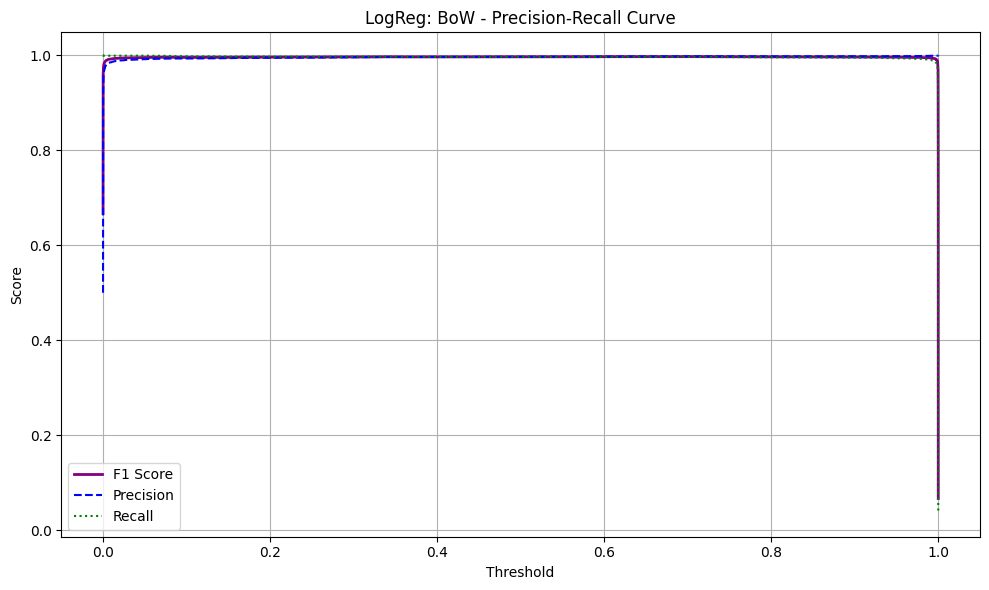


--- Threshold: 0.5 ---
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4243
        Fake       1.00      1.00      1.00      4242

    accuracy                           1.00      8485
   macro avg       1.00      1.00      1.00      8485
weighted avg       1.00      1.00      1.00      8485



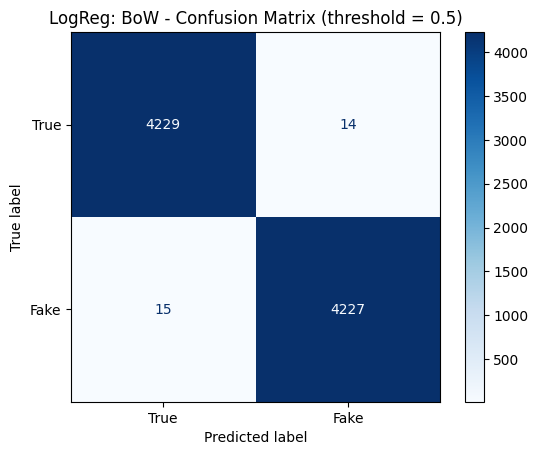


--- Threshold: 0.59 ---
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4243
        Fake       1.00      1.00      1.00      4242

    accuracy                           1.00      8485
   macro avg       1.00      1.00      1.00      8485
weighted avg       1.00      1.00      1.00      8485



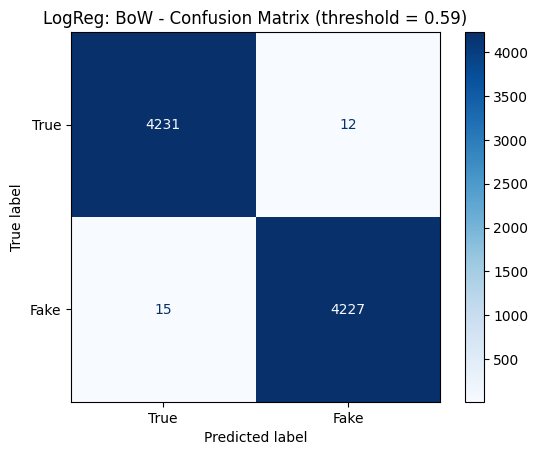


--- Threshold: 0.6 ---
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4243
        Fake       1.00      1.00      1.00      4242

    accuracy                           1.00      8485
   macro avg       1.00      1.00      1.00      8485
weighted avg       1.00      1.00      1.00      8485



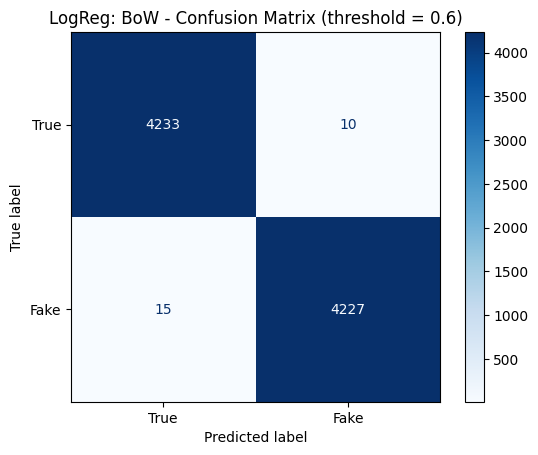


--- Threshold: 0.8 ---
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4243
        Fake       1.00      1.00      1.00      4242

    accuracy                           1.00      8485
   macro avg       1.00      1.00      1.00      8485
weighted avg       1.00      1.00      1.00      8485



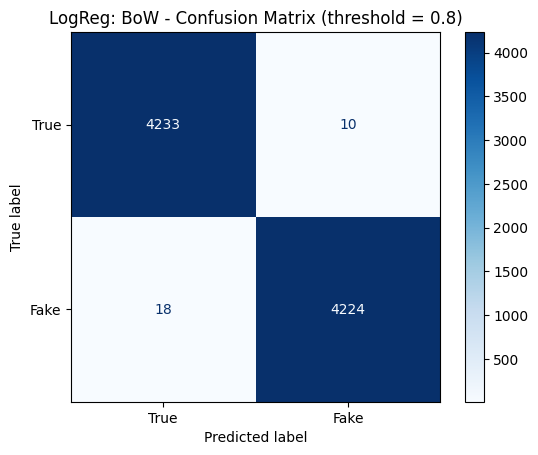

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities for class 1 using the best model from GridSearchCV
y_probs_bow = grid_search_bow.predict_proba(X_test_bow)[:, 1]

# Compute precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_bow)

# Compute F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Plot Precision, Recall, and F1 Score vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='purple', linewidth=2)
plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', linestyle=':', color='green')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('LogReg: BoW - Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate the logistic regression model trained on BoW features using multiple decision thresholds
thresholds_to_test_bow = [0.5, 0.59, 0.6, 0.8]

for threshold in thresholds_to_test_bow:
    y_pred_bow = (y_probs_bow >= threshold).astype(int)

    print(f"\n--- Threshold: {threshold} ---")

    print(classification_report(
        y_test,
        y_pred_bow,
        zero_division=0,
        labels=[0, 1],
        target_names=["True", "Fake"]
    ))

    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_bow,
        cmap='Blues',
        labels=[0, 1],
        display_labels=["True", "Fake"]
    )

    plt.title(f"LogReg: BoW - Confusion Matrix (threshold = {threshold})")
    plt.show()


### LogReg - Term Frequency-Inverse Document Frequency (TF-IDF)

#### LogReg: Train the Model (TF-IDF)

In [ ]:
# Logistic Regression Model
log_reg_tfidf = LogisticRegression()
log_reg_tfidf.fit(X_train_tfidf, y_train)
predicted_train_logreg_tfidf = log_reg_tfidf.predict(X_test_tfidf)

#### LogReg: Find ideal threshold (TF-IDF)

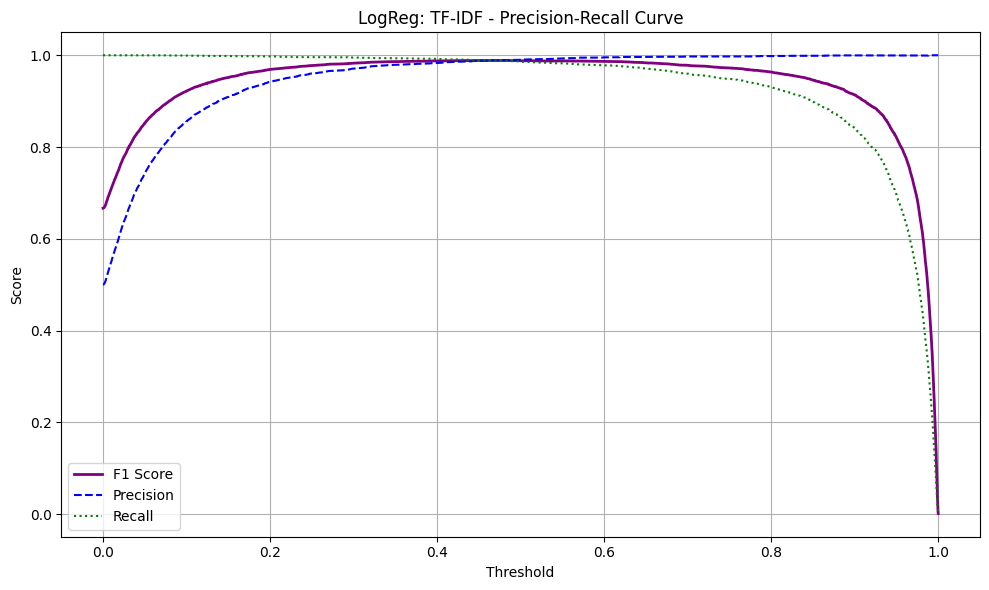

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities for class 1
y_probs_tfidf = log_reg_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Compute precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_tfidf)

# Compute F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Plot Precision, Recall, and F1 Score vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='purple', linewidth=2)
plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', linestyle=':', color='green')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('LogReg: TF-IDF - Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


#### LogReg: Evaluate on Test Data (TF-IDF)


--- Threshold: 0.49 ---
              precision    recall  f1-score   support

        True       0.99      0.99      0.99      4243
        Fake       0.99      0.99      0.99      4242

    accuracy                           0.99      8485
   macro avg       0.99      0.99      0.99      8485
weighted avg       0.99      0.99      0.99      8485



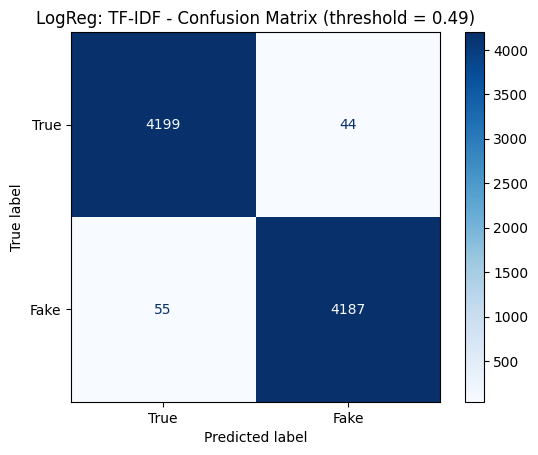


--- Threshold: 0.5 ---
              precision    recall  f1-score   support

        True       0.99      0.99      0.99      4243
        Fake       0.99      0.99      0.99      4242

    accuracy                           0.99      8485
   macro avg       0.99      0.99      0.99      8485
weighted avg       0.99      0.99      0.99      8485



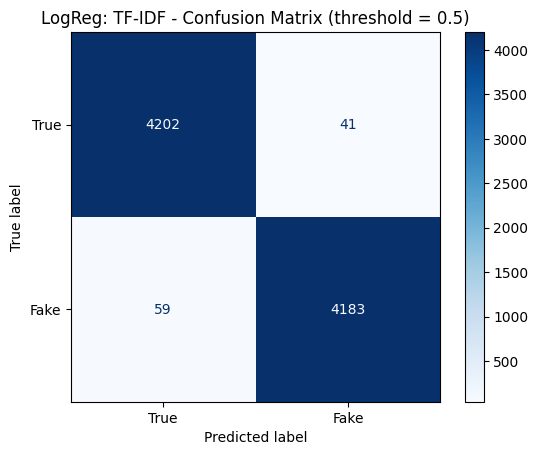


--- Threshold: 0.55 ---
              precision    recall  f1-score   support

        True       0.98      0.99      0.99      4243
        Fake       0.99      0.98      0.99      4242

    accuracy                           0.99      8485
   macro avg       0.99      0.99      0.99      8485
weighted avg       0.99      0.99      0.99      8485



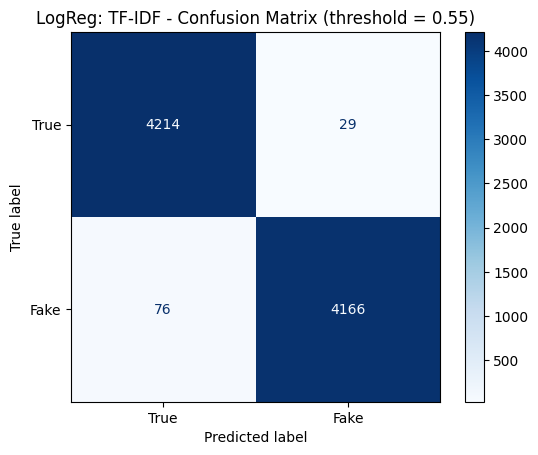

In [ ]:
# Evaluate the logistic regression model trained on TF-IDF features using multiple decision thresholds

thresholds_to_test_tfidf = [0.49, 0.5, 0.55]

for threshold in thresholds_to_test_tfidf:
    # Convert predicted probabilities into binary predictions based on current threshold
    y_pred_tfidf = (y_probs_tfidf >= threshold).astype(int)

    print(f"\n--- Threshold: {threshold} ---")

    # Display precision, recall, and F1 score for both classes
    print(classification_report(
        y_test,
        y_pred_tfidf,
        zero_division=0,
        labels=[0, 1],
        target_names=["True", "Fake"]
    ))

    # Plot the confusion matrix with consistent labeling
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_tfidf,
        cmap='Blues',
        labels=[0, 1],
        display_labels=["True", "Fake"]
    )

    plt.title(f"LogReg: TF-IDF - Confusion Matrix (threshold = {threshold})")
    plt.show()

#### LogReg: Tune the model (TF-IDF)

##### LogReg - Hyperparameter Grid Search (TF-IDF)

In [ ]:
# Define a pipeline for logistic regression on TF-IDF features
# Enables modular integration with GridSearchCV for hyperparameter tuning
pipeline = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000))
])

# Specify the hyperparameter grid for tuning
param_grid = {
    'logreg__C': [35000],           # Regularization strength (larger values reduce penalty)
    'logreg__penalty': ['l2'],             # L2 regularization preferred for interpretability and stability
    'logreg__solver': ['liblinear']        # Solver suited for small/medium datasets and L2 penalty
}

# Note: Prior grid search experiments included:
# C values: 0.01, 0.1, 1, 10, 20, 50, 1000, 10000, 20000, 50000
# penalty: 'elasticnet'
# solvers: 'saga', 'liblinear', 'newton-cg', 'sag', 'lsqr', 'lbfgs'


In [ ]:
from sklearn.model_selection import GridSearchCV

# Set up GridSearchCV to tune logistic regression hyperparameters using 5-fold cross-validation
grid_search_tfid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation for more stable performance estimates
    scoring='f1',
    n_jobs=-1             # Utilize all available cores for parallel execution
)

In [ ]:
# Fit the model
grid_search_tfid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logreg__C': [35000], 'logreg__penalty': ['l2'],
                         'logreg__solver': ['liblinear']},
             scoring='f1')

In [ ]:
# print the best parameters
print("Best Parameters:", grid_search_tfid.best_params_)

Best Parameters: {'logreg__C': 35000, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}


#### LogReg: Find ideal threshold (TF-IDF)

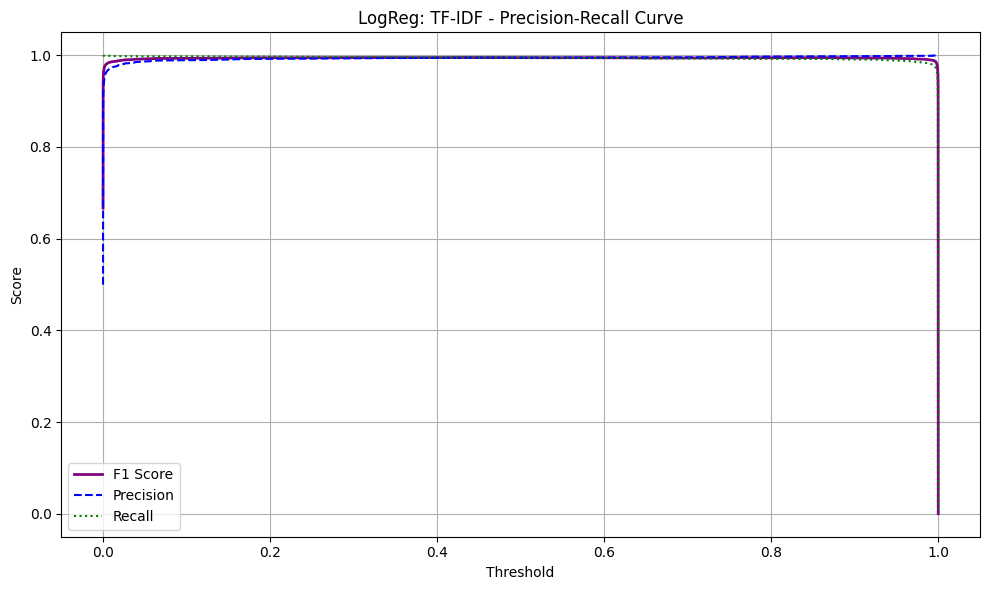

In [ ]:
## Precision Recall Curve

# Get predicted probabilities for class 1
y_probs_tfidf_tuned = grid_search_tfid.predict_proba(X_test_tfidf)[:, 1]

# Compute precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_tfidf_tuned)

# Compute F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Plot Precision, Recall, and F1 Score vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='purple', linewidth=2)
plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', linestyle=':', color='green')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('LogReg: TF-IDF - Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

#### LogReg: Evaluate Best Model on Test Data (TF-IDF)


--- Threshold: 0.47 ---
              precision    recall  f1-score   support

        True       1.00      0.99      0.99      4243
        Fake       0.99      1.00      0.99      4242

    accuracy                           0.99      8485
   macro avg       0.99      0.99      0.99      8485
weighted avg       0.99      0.99      0.99      8485



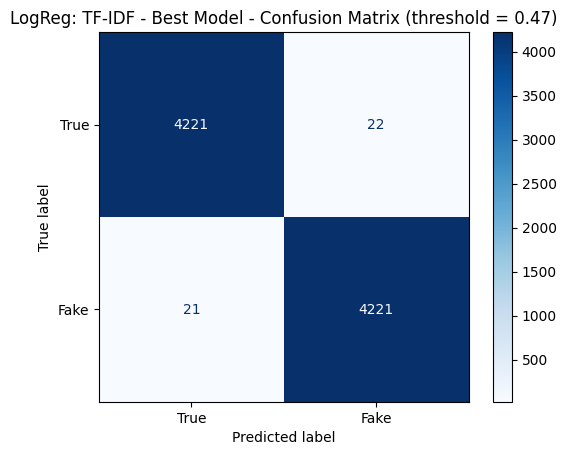


--- Threshold: 0.5 ---
              precision    recall  f1-score   support

        True       0.99      0.99      0.99      4243
        Fake       0.99      0.99      0.99      4242

    accuracy                           0.99      8485
   macro avg       0.99      0.99      0.99      8485
weighted avg       0.99      0.99      0.99      8485



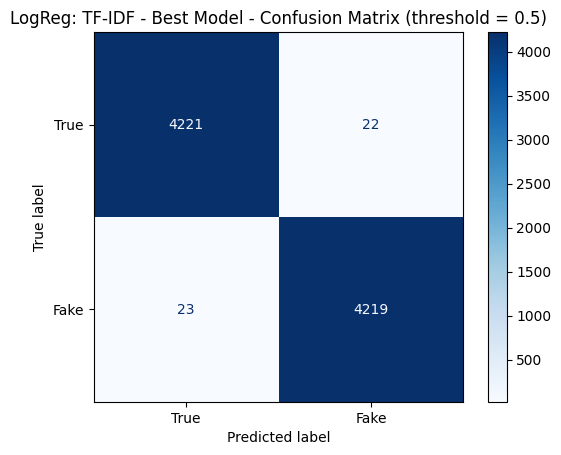


--- Threshold: 0.55 ---
              precision    recall  f1-score   support

        True       0.99      1.00      0.99      4243
        Fake       1.00      0.99      0.99      4242

    accuracy                           0.99      8485
   macro avg       0.99      0.99      0.99      8485
weighted avg       0.99      0.99      0.99      8485



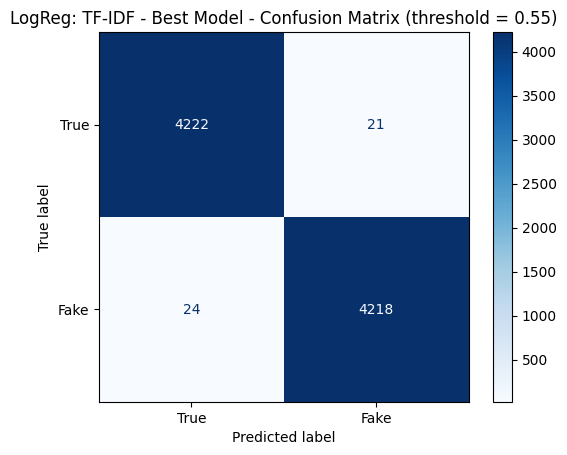


--- Threshold: 0.57 ---
              precision    recall  f1-score   support

        True       0.99      1.00      0.99      4243
        Fake       1.00      0.99      0.99      4242

    accuracy                           0.99      8485
   macro avg       0.99      0.99      0.99      8485
weighted avg       0.99      0.99      0.99      8485



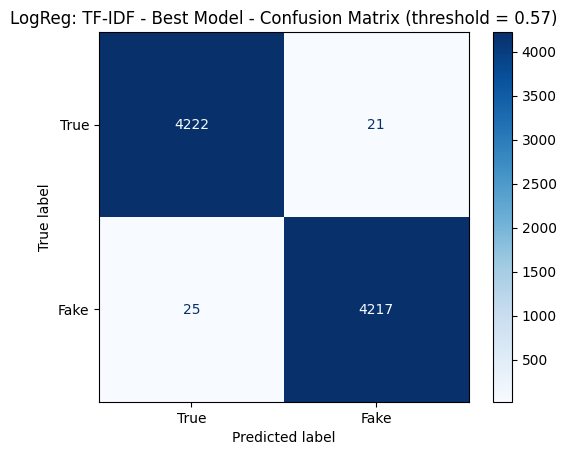


--- Threshold: 0.6 ---
              precision    recall  f1-score   support

        True       0.99      1.00      0.99      4243
        Fake       1.00      0.99      0.99      4242

    accuracy                           0.99      8485
   macro avg       0.99      0.99      0.99      8485
weighted avg       0.99      0.99      0.99      8485



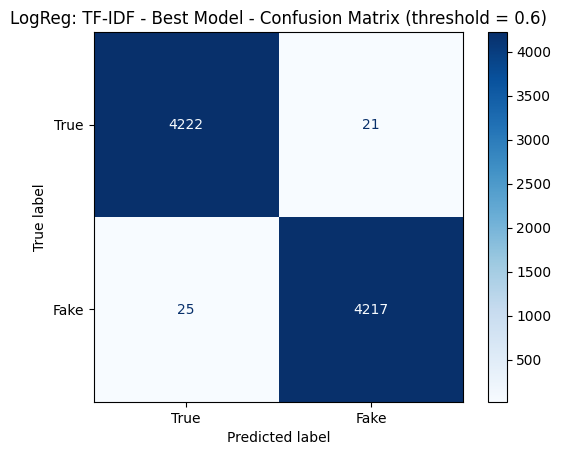


--- Threshold: 0.7 ---
              precision    recall  f1-score   support

        True       0.99      1.00      0.99      4243
        Fake       1.00      0.99      0.99      4242

    accuracy                           0.99      8485
   macro avg       0.99      0.99      0.99      8485
weighted avg       0.99      0.99      0.99      8485



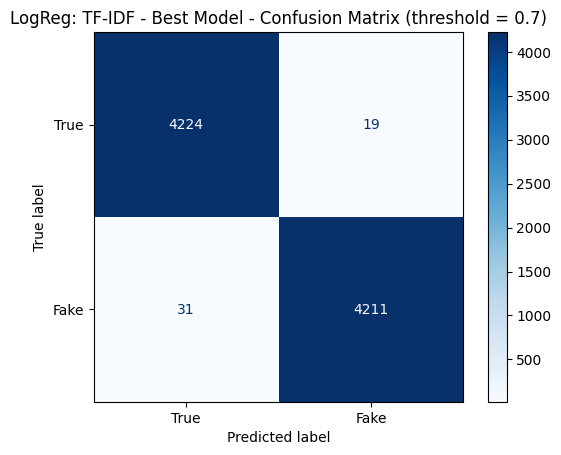


--- Threshold: 0.9 ---
              precision    recall  f1-score   support

        True       0.99      1.00      0.99      4243
        Fake       1.00      0.99      0.99      4242

    accuracy                           0.99      8485
   macro avg       0.99      0.99      0.99      8485
weighted avg       0.99      0.99      0.99      8485



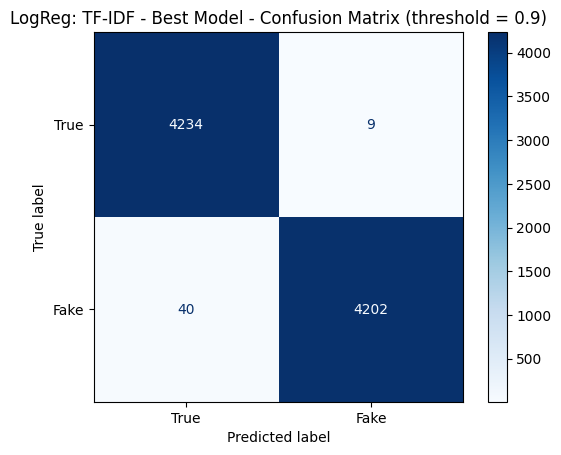

In [ ]:
# Evaluate the tuned TF-IDF logistic regression model across multiple decision thresholds

thresholds_to_test_tfidf = [0.47, 0.5, 0.55, 0.57, 0.6, 0.7, 0.9]

for threshold in thresholds_to_test_tfidf:
    # Convert predicted probabilities into binary predictions based on the selected threshold
    y_pred = (y_probs_tfidf_tuned >= threshold).astype(int)

    print(f"\n--- Threshold: {threshold} ---")

    # Print classification metrics including precision, recall, and F1 score
    print(classification_report(
        y_test,
        y_pred,
        zero_division=0,
        labels=[0, 1],
        target_names=["True", "Fake"]
    ))

    # Display confusion matrix for current threshold
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        cmap='Blues',
        labels=[0, 1],
        display_labels=["True", "Fake"]
    )

    plt.title(f"LogReg: TF-IDF - Best Model - Confusion Matrix (threshold = {threshold})")
    plt.show()


## Long short-term memory (LSTM)

In [ ]:
dataframes_to_keep = ["X_train", "X_test", "y_train", "y_test", "X_train_pad", "X_test_pad"]
clear_unwanted_dataframes(dataframes_to_keep)

Listing DataFrames in memory before cleanup:

>>> Number of DataFrames in Memory: 5 <<<

----------



<ipython-input-5-0a608d63154d>:22: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if isinstance(obj, pd.DataFrame):



>>> Number of DataFrames after garbage collection clearing: 5 <<<



<ipython-input-5-0a608d63154d>:31: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  count_after = sum(1 for obj in gc.get_objects() if isinstance(obj, pd.DataFrame))



>>> Number of DataFrames after final clearing: 3 <<<


<ipython-input-5-0a608d63154d>:49: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  count_final = sum(1 for obj in gc.get_objects() if isinstance(obj, pd.DataFrame))


### LSTM: Train the Model

In [ ]:
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Dynamically choose the metric to monitor
monitor_metric = 'val_loss' if use_validation else 'loss'

early_stop = EarlyStopping(
    monitor=monitor_metric,        # Switches based on validation usage
    patience=2,
    restore_best_weights=True,
    verbose=1
)

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128))  # Match tokenizer + max_seq_len
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val) if use_validation else None,
    epochs=5,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.6948 - loss: 0.5396
Epoch 2/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.8582 - loss: 0.3657
Epoch 3/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7675 - loss: 0.5396
Epoch 4/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9694 - loss: 0.1039
Epoch 5/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9897 - loss: 0.0357
Restoring model weights from the end of the best epoch: 5.


### LSTM: Evaluate on Test Data

In [ ]:
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9811 - loss: 0.0708
Test Accuracy: 0.9829 — Test Loss: 0.0663


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history, use_validation=False):
    """
    Plots training and validation loss/accuracy over epochs using consistent styling.

    Parameters:
    - history: Keras History object.
    - use_validation (bool): Whether to include validation curves.
    """

    colors = sns.color_palette("Blues", n_colors=2)

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss', color=colors[1], linewidth=2)
    if use_validation:
        plt.plot(history.history['val_loss'], label='Val Loss', color=colors[0], linewidth=2)
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', color=colors[1], linewidth=2)
    if use_validation:
        plt.plot(history.history['val_accuracy'], label='Val Accuracy', color=colors[0], linewidth=2)
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


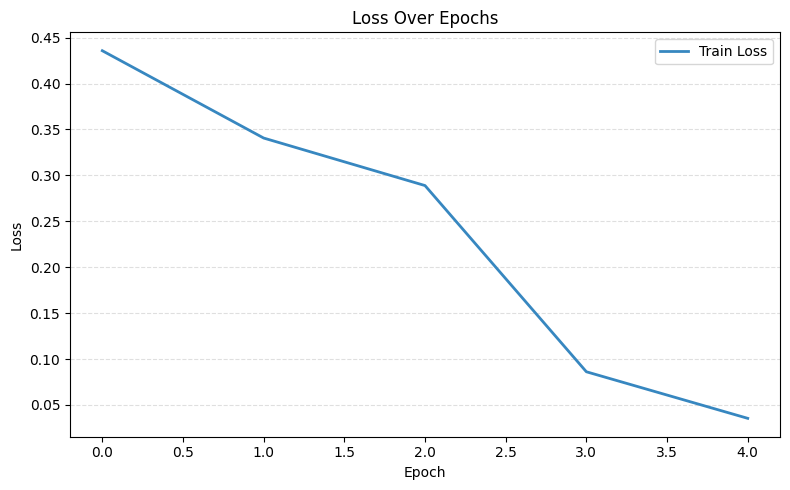

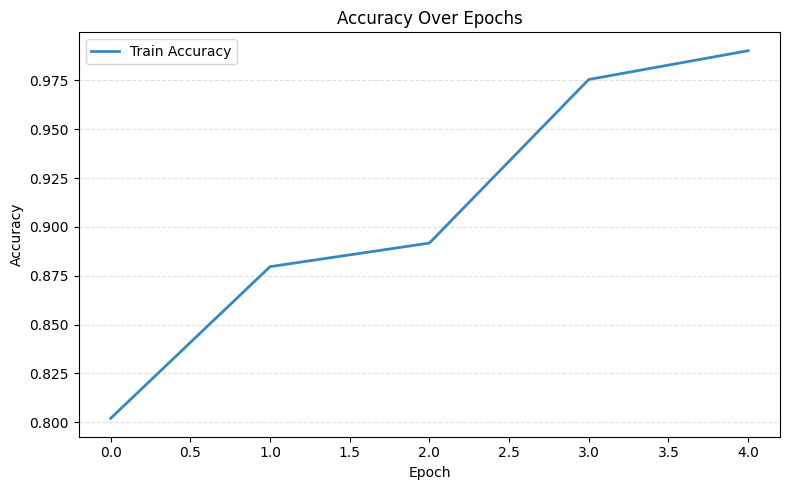

In [ ]:
plot_training_history(history, use_validation=use_validation)

266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

        True       0.99      0.97      0.98      4243
        Fake       0.97      0.99      0.98      4242

    accuracy                           0.98      8485
   macro avg       0.98      0.98      0.98      8485
weighted avg       0.98      0.98      0.98      8485



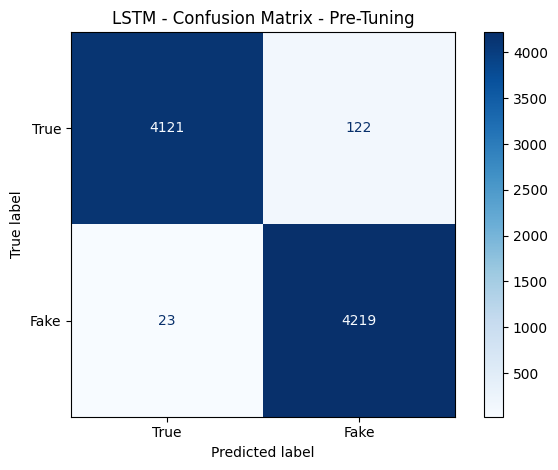

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype("int")

print(classification_report(
    y_test, y_pred,
    target_names=["True", "Fake"]))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

# Plot
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["True", "Fake"]
    )

disp.plot(cmap="Blues")
plt.grid(False)
plt.title("LSTM - Confusion Matrix - Pre-Tuning")
plt.tight_layout()
plt.show()


### LSTM: Tune the Model

#### LSTM: Hyperparameter Grid Search

In [ ]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Manual seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define updated search space
param_grid = {
    'embedding_dim': [64, 128, 200],
    'lstm_units': [64, 128, 256],
    'dropout': [0.2, 0.3],
    'learning_rate': [1e-3, 5e-4, 1e-4]
}

# Generate random combinations
random_combinations = [
    {
        'embedding_dim': random.choice(param_grid['embedding_dim']),
        'lstm_units': random.choice(param_grid['lstm_units']),
        'dropout': random.choice(param_grid['dropout']),
        'learning_rate': random.choice(param_grid['learning_rate'])
    }
    for _ in range(4)
]

# Include baseline config
all_trials = [{
    'embedding_dim': 128,
    'lstm_units': 128,
    'dropout': 0.3,
    'learning_rate': 1e-3
}] + random_combinations

results = []

# Run trials
for i, params in enumerate(all_trials):
    print(f"\nTrial {i}: {params}")

    start_time = time.time()

    # Clear session and reset seeds
    K.clear_session()
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

    # Build model
    model = Sequential()
    model.add(Embedding(input_dim=20000, output_dim=params['embedding_dim']))
    model.add(LSTM(params['lstm_units'], return_sequences=False))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Early stopping setup
    early_stop = EarlyStopping(
        monitor='val_loss' if use_validation else 'loss',
        patience=2,
        restore_best_weights=True,
        verbose=0
    )

    # Train
    history = model.fit(
        X_train_pad,
        y_train,
        validation_data=(X_val_pad, y_val) if use_validation else None,
        epochs=5,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate
    y_pred_probs = model.predict(X_test_pad, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype("int").flatten()

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    duration = time.time() - start_time
    total_params = model.count_params()

    # Determine best epoch (lowest loss)
    best_epoch = int(np.argmin(history.history['val_loss'] if use_validation else history.history['loss'])) + 1

    print(f"Best Epoch: {best_epoch} | Accuracy: {acc:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | Time: {duration:.1f}s | Params: {total_params}")

    # Save result
    results.append({
        'Trial': i,
        'embedding_dim': params['embedding_dim'],
        'lstm_units': params['lstm_units'],
        'dropout': params['dropout'],
        'learning_rate': params['learning_rate'],
        'Best Epoch': best_epoch,
        'Accuracy': acc,
        'Recall': rec,
        'F1 Score': f1,
        'Train Time (s)': round(duration, 1),
        'Param Count': total_params
    })

# Sort and display results
results_df = pd.DataFrame(sorted(results, key=lambda x: x['F1 Score'], reverse=True))
from IPython.display import display
display(results_df)



Trial 0: {'embedding_dim': 128, 'lstm_units': 128, 'dropout': 0.3, 'learning_rate': 0.001}
Best Epoch: 5 | Accuracy: 0.9930 | Recall: 0.9894 | F1: 0.9930 | Time: 101.7s | Params: 2691713

Trial 1: {'embedding_dim': 200, 'lstm_units': 64, 'dropout': 0.2, 'learning_rate': 0.0001}
Best Epoch: 5 | Accuracy: 0.9780 | Recall: 0.9712 | F1: 0.9778 | Time: 97.6s | Params: 4067905

Trial 2: {'embedding_dim': 128, 'lstm_units': 64, 'dropout': 0.2, 'learning_rate': 0.001}
Best Epoch: 5 | Accuracy: 0.9877 | Recall: 0.9948 | F1: 0.9878 | Time: 100.7s | Params: 2609473

Trial 3: {'embedding_dim': 200, 'lstm_units': 64, 'dropout': 0.2, 'learning_rate': 0.0001}
Best Epoch: 5 | Accuracy: 0.9283 | Recall: 0.8970 | F1: 0.9260 | Time: 102.0s | Params: 4067905

Trial 4: {'embedding_dim': 128, 'lstm_units': 64, 'dropout': 0.2, 'learning_rate': 0.001}
Best Epoch: 5 | Accuracy: 0.9935 | Recall: 0.9929 | F1: 0.9935 | Time: 94.3s | Params: 2609473


,Trial,embedding_dim,lstm_units,dropout,learning_rate,Best Epoch,Accuracy,Recall,F1 Score,Train Time (s),Param Count
0,4,128,64,0.2,0.0010,5,0.993518,0.992928,0.993513,94.3,2609473
1,0,128,128,0.3,0.0010,5,0.993047,0.989392,0.993020,101.7,2691713
2,2,128,64,0.2,0.0010,5,0.987743,0.994814,0.987828,100.7,2609473
3,1,200,64,0.2,0.0001,5,0.977961,0.971240,0.977809,97.6,4067905
4,3,200,64,0.2,0.0001,5,0.928344,0.896983,0.926016,102.0,4067905


#### LSTM: Visualize Grid Search Results

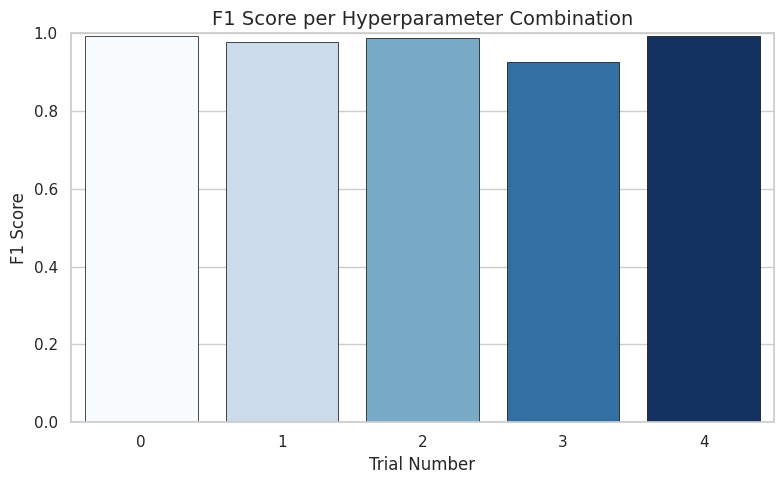

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for consistency
sns.set(style="whitegrid")

# Plot F1 scores by trial number
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df,
    x="Trial",
    y="F1 Score",
    palette="Blues",
    hue="Trial",
    edgecolor="black",
    linewidth=0.5,
    legend=False
    )

plt.title("F1 Score per Hyperparameter Combination", fontsize=14)
plt.xlabel("Trial Number", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


### LSTM: Evaluate Best Model on Test Data

In [ ]:
best_params = results_df.iloc[0]  # Already sorted by F1 descending

best_embedding_dim = int(best_params['embedding_dim'])
best_lstm_units = int(best_params['lstm_units'])
best_dropout = float(best_params['dropout'])
best_learning_rate = float(best_params['learning_rate'])


In [ ]:
# Clear session
K.clear_session()
tf.random.set_seed(SEED)

# Build best model
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=best_embedding_dim))
model.add(LSTM(best_lstm_units, return_sequences=False))
model.add(Dropout(best_dropout))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=best_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss' if use_validation else 'loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# Fit best model
history = model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val) if use_validation else None,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6236 - loss: 0.6181
Epoch 2/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7420 - loss: 0.5506
Epoch 3/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.8025 - loss: 0.4712
Epoch 4/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8409 - loss: 0.3827
Epoch 5/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9854 - loss: 0.0575
Epoch 6/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9976 - loss: 0.0136
Epoch 7/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9954 - loss: 0.0195
Epoch 8/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9976 - loss: 0.0125
Epoch 9/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9986 - loss: 0.0090
Epoch 10/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9991 - loss: 0.0060
Restoring model weights from the end of the best epoch: 10.


266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4243
        Fake       1.00      1.00      1.00      4242

    accuracy                           1.00      8485
   macro avg       1.00      1.00      1.00      8485
weighted avg       1.00      1.00      1.00      8485



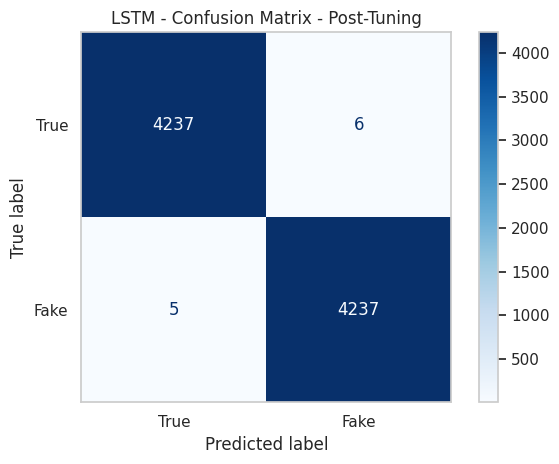

In [ ]:
y_test_pred_probs = model.predict(X_test_pad)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(
    y_test, y_test_pred,
    labels=[0,1],
    target_names=["True", "Fake"]))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])

# Plot
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["True", "Fake"])

disp.plot(cmap="Blues")
plt.grid(False)
plt.title("LSTM - Confusion Matrix - Post-Tuning")
plt.tight_layout()
plt.show()


## BERT

### BERT: Load Pre-Trained Model

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

### BERT: Downsample Dataframe

In [ ]:
batch_1 = df.groupby('target').sample(n=3000, random_state=42)

#Shuffle the dataset

batch_1 = batch_1.sample(frac=1, random_state=42).reset_index(drop=True)

#### BERT: Tokenize the Sample

In [ ]:
"""
We must specify the maximum argument length  as 512 tokens
is the maximum amount the model can handle,
and our text column exceeds this limit.

After a crashout of RAM I decreased batch size and max length.

"""

tokenized = batch_1['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=300, truncation=True)))

#### BERT: Padding the Sample

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(6000, 300)

#### BERT: Masking the Sample

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(6000, 300)

In [ ]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
target = batch_1['target']

#### BERT: Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

### BERT: Hyperparameter Grid Search

In [ ]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(X_train, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': np.float64(5.263252631578947)}
best scrores:  0.9848888888888888


In [ ]:
lr_clf = LogisticRegression(**grid_search.best_params_)
lr_clf.fit(X_train, y_train)

LogisticRegression(C=np.float64(5.263252631578947))

### BERT: Evaluate Model

In [ ]:
y_pred = lr_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Fake       0.98      0.99      0.98       600
        True       0.99      0.98      0.98       600

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



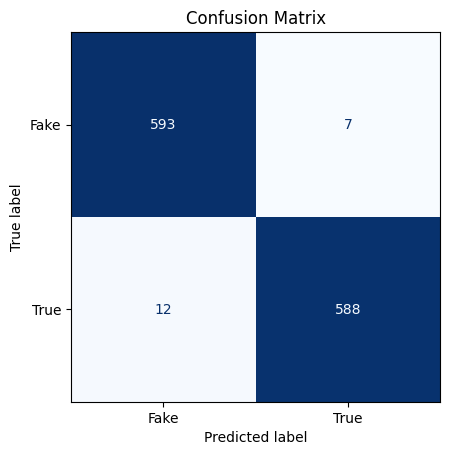

In [ ]:

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["True", "Fake"])

disp.plot(cmap='Blues', colorbar=False)
plt.title("Confusion Matrix")
plt.show()


### BERT: Saving Model

In [ ]:
import joblib
joblib.dump(lr_clf, 'bert_logreg_model.pkl')

## Mistral AI - LLM

### Mistral: Installing & Upgrading Libraries

In [ ]:
# !pip install --upgrade bitsandbytes
# !pip install --upgrade transformers
# !pip install --upgrade accelerate

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [ ]:
from huggingface_hub import login

login("##########################################") #API KEY - DONT SHARE THIS.

In [ ]:
!nvidia-smi

Tue May 20 17:44:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             41W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Mistral: Load the Model

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)


model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.3",
    quantization_config=bnb_config,
    device_map="auto"
)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3")

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

### Mistral: Create Prompt Template

### Mistral: Simple Prompt

In [ ]:
def simple_shot_prompt(text):
    return f"""Classify this news article as "Fake" or "True":

Article: "{text}"

Answer:"""

### Mistral: Few-Shot Prompt

In [ ]:
# Sample a few rows with labels
examples = df.groupby('target').sample(n=2, random_state=42)  # 2 from each class = 4 total
examples = examples.sample(n=3, random_state=1).reset_index(drop=True)

In [ ]:
# Truncate long articles
def truncate(text, max_words=100):
    return " ".join(text.split()[:max_words])

In [ ]:
def few_shot_prompt(text):
    ex = examples.copy()
    ex["text"] = ex["text"].apply(lambda x: truncate(x, max_words=60))
    return f"""You are a fact-checking assistant. Classify each news article as "Fake" or "True".

Examples:
Article: "{ex.iloc[0]['text']}"
Answer: {ex.iloc[0]["target"]}

Article: "{ex.iloc[1]['text']}"
Answer: {ex.iloc[1]["target"]}

Article: "{ex.iloc[2]['text']}"
Answer: {ex.iloc[2]["target"]}

Now classify this article:
Article: "{truncate(text, max_words=100)}"
Answer:"""

### Mistral: Classification Function

In [ ]:
def classify_article(text, prompt_fn, max_new_tokens=5):
    prompt = prompt_fn(text)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = decoded.split("Answer:")[-1].strip().split()[0]
    return answer

### Mistral: Evaluate Simple Shot Prompt

In [ ]:
from tqdm.notebook import tqdm

batch_2 = df.groupby('class').sample(n=3000, random_state=42)


batch_2 = batch_2.sample(frac=1, random_state=42).reset_index(drop=True)

predictions = []
for i, row in tqdm(batch_2.iterrows(), total=len(batch_2)):
    try:
        truncated_text = truncate(row["text"])
        prediction = classify_article(truncated_text, simple_shot_prompt)
    except Exception as e:
        prediction = "ERROR"
        print(f"Error on row {i}: {e}")
    predictions.append(prediction)

    # Save every 25 rows to avoid loss
    if i % 25 == 0:
        temp_df = batch_2.iloc[:i+1].copy()
        temp_df["llm_prediction"] = predictions[:i+1]
        temp_df.to_csv("llm_partial_output.csv", index=False)

batch_2["llm_prediction"] = predictions

  0%|          | 0/6000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        Fake       0.94      0.49      0.64      1699
        True       0.75      0.98      0.85      2676

    accuracy                           0.79      4375
   macro avg       0.85      0.74      0.75      4375
weighted avg       0.83      0.79      0.77      4375



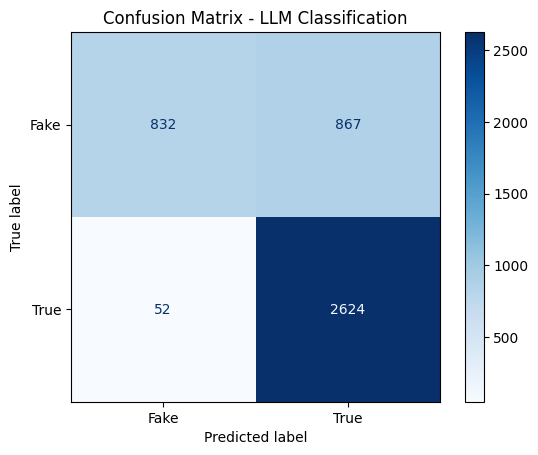

In [ ]:
# Clean up predictions (include "false" as fake)
def clean_prediction(pred):
    if not isinstance(pred, str):
        return "OTHER"
    pred = pred.strip().lower()
    if pred.startswith("fake") or pred.startswith("false"):
        return "Fake"
    elif pred.startswith("true"):
        return "True"
    else:
        return "OTHER"


batch_2['llm_prediction'] = batch_2['llm_prediction'].apply(clean_prediction)

# Filter only valid predictions
filtered_df = batch_2[batch_2['llm_prediction'].isin(["Fake", "True"])]

y_true = filtered_df["class"]
y_pred = filtered_df["llm_prediction"]

# Classification report
print(classification_report(y_true, y_pred, labels=["Fake", "True"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["Fake", "True"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "True"])

disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - LLM Classification")
plt.grid(False)
plt.show()


### Mistral: Evaluate Few-Shot Prompt

In [ ]:

batch_3 = df.groupby('class').sample(n=1000, random_state=42)


batch_3 = batch_3.sample(frac=1, random_state=42).reset_index(drop=True)

predictions = []
for i, row in tqdm(batch_3.iterrows(), total=len(batch_3)):
    try:
        truncated_text = truncate(row["text"])
        prediction = classify_article(truncated_text, few_shot_prompt)
    except Exception as e:
        prediction = "ERROR"
        print(f"Error on row {i}: {e}")
    predictions.append(prediction)

    # Save every 25 rows to avoid loss
    if i % 25 == 0:
        temp_df = batch_3.iloc[:i+1].copy()
        temp_df["llm_prediction"] = predictions[:i+1]
        temp_df.to_csv("llm_partial_output_2.csv", index=False)

batch_3["llm_prediction"] = predictions

  0%|          | 0/2000 [00:00<?, ?it/s]

Error on row 695: list index out of range
Error on row 1375: list index out of range
Error on row 1614: list index out of range


              precision    recall  f1-score   support

        Fake       0.74      0.56      0.64       990
        True       0.65      0.81      0.72       999

    accuracy                           0.68      1989
   macro avg       0.69      0.68      0.68      1989
weighted avg       0.69      0.68      0.68      1989



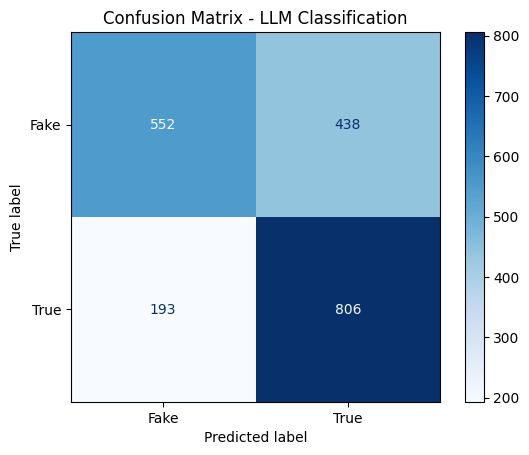

In [ ]:
# Clean up predictions (remove errors if any)


batch_3['llm_prediction'] = batch_3['llm_prediction'].apply(clean_prediction)

filtered_df = batch_3[batch_3['llm_prediction'].isin(["Fake", "True"])]

y_true = filtered_df["class"]
y_pred = filtered_df["llm_prediction"]

# Classification report
print(classification_report(y_true, y_pred, labels=["Fake", "True"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["Fake", "True"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "True"])

disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - LLM Classification")
plt.grid(False)
plt.show()
